## Sentiment Analysis of @mikegravel Followers  

It would be helpful to know what topics are of most interest to your followers; if issues or importance can be identified among followers, statements can be released strategically to address concerns. As trends develop and occur, one can stay in sync; sentiment analysis of the most frequent terms and topics can add detail to trends and offer a preview of collective thought and opinion among followers.

Reference:  
https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/

In [169]:
import numpy as np  
import pandas as pd  
import re  
import nltk  
import urllib.request, json 
import matplotlib.pyplot as plt  
%matplotlib inline

## Dataset 1: follower tweets of 06/22/2019

The data examined is a single sample of tweets from the followers of @mikegravel, posted in JSON format on github.

It's important to consider the context of the sample; the first democratic debates took place on June 26th-27th. Alexandria Ocasio-Cortez had just tweeted her 'concentration camp' tweet on June 18th and the topic was still trending on the twittersphere. Tensions with Iran were running high.

In [170]:
with urllib.request.urlopen("https://raw.githubusercontent.com/aliceafriedman/team6_final/master/mikegravel1561157054.0137448_followers.json") as url:
    gravel = pd.read_json(url.read().decode())

In [171]:
gravel.head()

screen_name  verified        location  followers_count  \
0  andyverderosa      True      nyc via sf             1369   
1        mathrok     False  Wisconsin, USA              817   
2        g_stetz     False                               83   
3     slushfund_     False                                0   
4        Ian_C_H     False                                5   

                                                                                                                tweet_text  \
0           I mean who among us hasn’t called off one or two proverbial drone strikes that we ourselves initially ordered?   
1  @OneNationOrg You know a response video with testimonies of the perpetual horror stories our for-profit healthcare… ...   
2  RT @halaljew: it owns that Lisa Simpson has a better understanding of the function that police serve in a capitalist...   
3                                                                                                                     None   
4                                                                                                                     None   

   retweet_count  favorite_count  
0            0.0             4.0  
1            0.0             3.0  
2        17783.0             0.0  
3            NaN             NaN  
4            NaN             NaN

In [172]:
gravel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98266 entries, 0 to 98265
Data columns (total 7 columns):
screen_name        98266 non-null object
verified           98266 non-null bool
location           98266 non-null object
followers_count    98266 non-null int64
tweet_text         85686 non-null object
retweet_count      85686 non-null float64
favorite_count     85686 non-null float64
dtypes: bool(1), float64(2), int64(1), object(3)
memory usage: 4.6+ MB


There are 85k tweets to analyze; this total includes retweets or original tweets of followers. A quick look at the data reveals the lack of verified users in the sample; 99% of our sample is composed of unverified users.
 
 In order to clean and thoroughly examine the tweets, let's isolate the tweet text.

In [174]:
features = gravel.iloc[:, 4].values 
print(features)

['I mean who among us hasn’t called off one or two proverbial drone strikes that we ourselves initially ordered?'
 '@OneNationOrg You know a response video with testimonies of the perpetual horror stories our for-profit healthcare… https://t.co/CrqOtCR2aQ'
 'RT @halaljew: it owns that Lisa Simpson has a better understanding of the function that police serve in a capitalist society then the major…'
 ...
 'This is an account for following members of and candidates for the US House of Representatives and US Senate.'
 'Courtesy of Reddit. Parody of "All I wanted was a video of my dive" video. https://t.co/OAFJ3e7GIL (woman blocks views)'
 'RT @karanormal: And as a reminder, because my Facebook feed is quickly proving we need it: It is LAW to move over for stationary emergency…']


#### How does one assess sentiment?

We decided to try the module `vaderSentiment` to assess sentiment on the tweets.

From the site:  
"VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media."  

Four scores are calculated for each tweet: positive, negative, neutral, and compound scores indicate sentiment. `VADER` calculates scores based on terms, capitalization, punctuation, and some emojis. It assesses negative, neutral and positive sentiment as a percent, then calculates the compound score on a normalized scale from -1 to 1 with 1 being the most positive.

Data are cleaned in preparation for the initial assessment; we'll conduct a little demonstration before applying to the data.

Resource:  
https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f

In [175]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

#define a function for testing.
def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

#### A short demonstration

In [176]:
sentiment_analyzer_scores("This concert is so amazing and super cool.")

This concert is so amazing and super cool. {'neg': 0.0, 'neu': 0.306, 'pos': 0.694, 'compound': 0.9068}


In [177]:
sentiment_analyzer_scores("The concert is so amazing and SUPER COOL!")

The concert is so amazing and SUPER COOL! {'neg': 0.0, 'neu': 0.276, 'pos': 0.724, 'compound': 0.9336}


In [178]:
sentiment_analyzer_scores("The concert is so amazing and SUPER COOL but it rained and I was disappointed.")

The concert is so amazing and SUPER COOL but it rained and I was disappointed. {'neg': 0.188, 'neu': 0.454, 'pos': 0.358, 'compound': 0.4114}


As you can see, the compound score is raised with the inclusion of the exclamation point. The text of the third string is deemed 18.8% negative, 45.4% neutral and 35.8% positive, with a compound score of 0.4114.

We're ready to roll.

In [179]:
#remove rows with no tweet text to analyze
features = [x for x in features if x is not None]

features = [re.sub(r'[\n]', ' ', x) for x in features] #remove \m line breaks
features = [re.sub(r'&amp;', ' ', x) for x in features] #remove ampersand trash code
features = [re.sub(r':', ' ', x) for x in features] #remove colons that appear after retweet mentions
features = [re.sub(r'https', ' ', x) for x in features] #remove https as a word, resulting from above
features = [re.sub(r"[\"\'’….,]", '', x) for x in features] #remove many special characters, including special apostrophe
features = [re.sub(r"^RT ", '', x) for x in features] #remove RT (retweet symbol)

#keep a copy of the original set for reference and troubleshooting
scores = features

#make a dataframe for use later.
features2 = pd.DataFrame(features)
features2.columns = ['tweet_text']

#the most problematic tweet text-wise; this originally contained \n throughout.
samp = features2.loc[[49618]].to_string()
print(sentiment_analyzer_scores(samp))


                                                                                                                    tweet_text
49618  @EveryDNA  heart-eyes flower DNA  😍　🌷    😍🌷 　 🌷 　🌷😍  🌷　😍 🌷　　😍 🌷　　😍  🌷　😍    🌷😍 　  😍 　😍 🌷  😍　 🌷 😍　　🌷 😍　　 🌷  😍　  🌷 　😍🌷 ... {'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.9849}
None


The string above receives a compound score of 0.9849 (neutral 62.1% and positive 37.9%).  

The loop below calculates sentiment and stores in the format of a dictionary within a list.

In [180]:
i=0
for feature in scores:
    vs = analyzer.polarity_scores(feature)
    scores[i] = ("{}".format(str(vs)))
    i+=1

The list is converted to a dataframe and split into separate columns.

In [181]:
scores2 = pd.DataFrame(scores)
scores2.columns = ['scores']
scores2['scores'] = scores2['scores'].astype(str)

f = lambda x: x["scores"].split("'neg': ")[1].split(",")[0]
scores2['neg']  = scores2.apply(f, axis=1)

f = lambda x: x["scores"].split("'neu': ")[1].split(",")[0]
scores2['neu']  = scores2.apply(f, axis=1)

f = lambda x: x["scores"].split("'pos': ")[1].split(",")[0]
scores2['pos']  = scores2.apply(f, axis=1)

f = lambda x: x["scores"].split("'compound': ")[1].split("}")[0]
scores2['compound']  = scores2.apply(f, axis=1)

scores2 = scores2.drop("scores", axis = 1)

scores2.head(5)

neg    neu    pos compound
0  0.128  0.872    0.0  -0.3612
1  0.198  0.802    0.0  -0.5719
2    0.0  0.873  0.127   0.4404
3    0.0  0.886  0.114   0.4497
4    0.0    1.0    0.0      0.0

### The most positive and most negative tweets, according to `VADER`: Dataset 1

The data above is merged with the original unaltered tweet text stored in `features2`. The resulting data frame is sorted by compound scores and head and tail displayed.  

Each column is converted to numeric for accurate sorting.

In [182]:
features_scores = features2.join(scores2) #merge

#convert to numeric for sorting
features_scores[['pos','neg','neu','compound']] = features_scores[['pos','neg','neu','compound']].apply(pd.to_numeric)

#sort the dataframe
features_scores = features_scores.sort_values('compound',ascending=False)

#expand the display of the column
pd.options.display.max_colwidth = 120
features_scores.head(10)

tweet_text  \
34151  @liamgallagher  Ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha h...   
57878  A Truly Happy Awesome Amazing Blessed Fathers Day May You Only Be Truly Blessed With Excellent Health True Friends  ...   
49618  @EveryDNA  heart-eyes flower DNA  😍　🌷    😍🌷 　 🌷 　🌷😍  🌷　😍 🌷　　😍 🌷　　😍  🌷　😍    🌷😍 　  😍 　😍 🌷  😍　 🌷 😍　　🌷 😍　　 🌷  😍　  🌷 　😍🌷 ...   
69942                                                            @gfstarr1 I love love love that you say love love love Me too   
64508  @IlhanMN Our God is an awesome God He reigns from Heaven above With Wisdom Power and Love Our God is an AWESOME G   ...   
84647  YOGA BEAUTY SECRETS - INSPIRE by Melinda shears  Love inspires creativity within us creating goodness http //tco/iCB...   
30486  @LigmaBullz I had to do 2 runs of accutane but its so worth it! Definitely stock up on the chapstick  ) Good luck yo...   
76362  Ordered these T-shirts for the Pride Festival   Parade in Reno on July 27th Love is Love   FREE HUGS from Grandm   /...   
24821  I love this platonic love is honestly my favorite and in my opinion the strongest love that Ive seen   //tco/bFJZexTX6q   
71573  @GameGrumps  👌 GIVEAWAY TIME! 👌  1 randomly chosen recipient wins the gift box of their choice and chooses a friend ...   

       neg    neu    pos  compound  
34151  0.0  0.010  0.990    0.9976  
57878  0.0  0.205  0.795    0.9880  
49618  0.0  0.613  0.387    0.9872  
69942  0.0  0.192  0.808    0.9803  
64508  0.0  0.365  0.635    0.9779  
84647  0.0  0.274  0.726    0.9746  
30486  0.0  0.458  0.542    0.9728  
76362  0.0  0.406  0.594    0.9718  
24821  0.0  0.377  0.623    0.9702  
71573  0.0  0.432  0.568    0.9696

In [183]:
features_scores.tail(10)

tweet_text  \
8039       @joshfoxfilm  No  War  On  Iran  No  War  On  Iran  No  War  On  Iran  No  War  On  Iran  No  War  On  Iran  No  Wa   
70169  @peterdaou  A war on migrants  A war on women  A war on people of color  A war on the poor  A war on the sick  A war...   
47264  @peterdaou  A war on migrants  A war on women  A war on people of color  A war on the poor  A war on the sick  A war...   
19965  @jacobinmag  No War on Iran No War on Iran No War on Iran No War on Iran No War on Iran No War on Iran No War on Ira...   
4280   @jacobinmag  No War on Iran No War on Iran No War on Iran No War on Iran No War on Iran No War on Iran No War on Ira...   
29161  @jacobinmag  No War on Iran No War on Iran No War on Iran No War on Iran No War on Iran No War on Iran No War on Ira...   
26901  @ScottHech  No more wars No more wars No more wars No more wars No more wars No more wars No more wars No more wars ...   
49604  @GreenJobsNY  NO WAR WITH IRAN  NO WAR WITH IRAN  NO WAR WITH IRAN  NO WAR WITH IRAN  NO WAR WITH IRAN  NO WAR WITH ...   
42379  @chunkled  FUCK FUCK FUCK  FUCK FUCK FUCK FUCK FUCK  FUCK            FUCK FUCK            FUCK FUCK            FUCK ...   
60886  @mgoldst  My creative process   ugh wtf ugh wtf ugh wtf ugh wtf ugh wtf ugh wtf ugh wtf ugh wtf ugh wtf ugh wtf ugh ...   

         neg    neu    pos  compound  
8039   0.732  0.268  0.000   -0.9844  
70169  0.665  0.335  0.000   -0.9846  
47264  0.665  0.335  0.000   -0.9846  
19965  0.731  0.269  0.000   -0.9931  
4280   0.731  0.269  0.000   -0.9931  
29161  0.731  0.269  0.000   -0.9931  
26901  0.846  0.154  0.000   -0.9945  
49604  0.779  0.221  0.000   -0.9951  
42379  0.985  0.015  0.000   -0.9972  
60886  0.936  0.033  0.032   -0.9978

The highest scored tweets mention 'God', 'love', and 'Pride'; the highest rated tweet is basically laughter with a compound score of 0.9976. There appears to be an offer for games and gifts as well.

The lowest scores are retweets of "No War on Iran" and "ugh wtf" at -0.9931 and -0.9978 respectively.  

#### Overall mean compound sentiment: Dataset 1

In [235]:
features_scores['compound'].mean()

0.030840474523261264

Mean compound sentiment of the entire sample is mostly neutral but slightly positive at 0.031.

Using these data let's check the distribution of sentiment with scatter plots. 

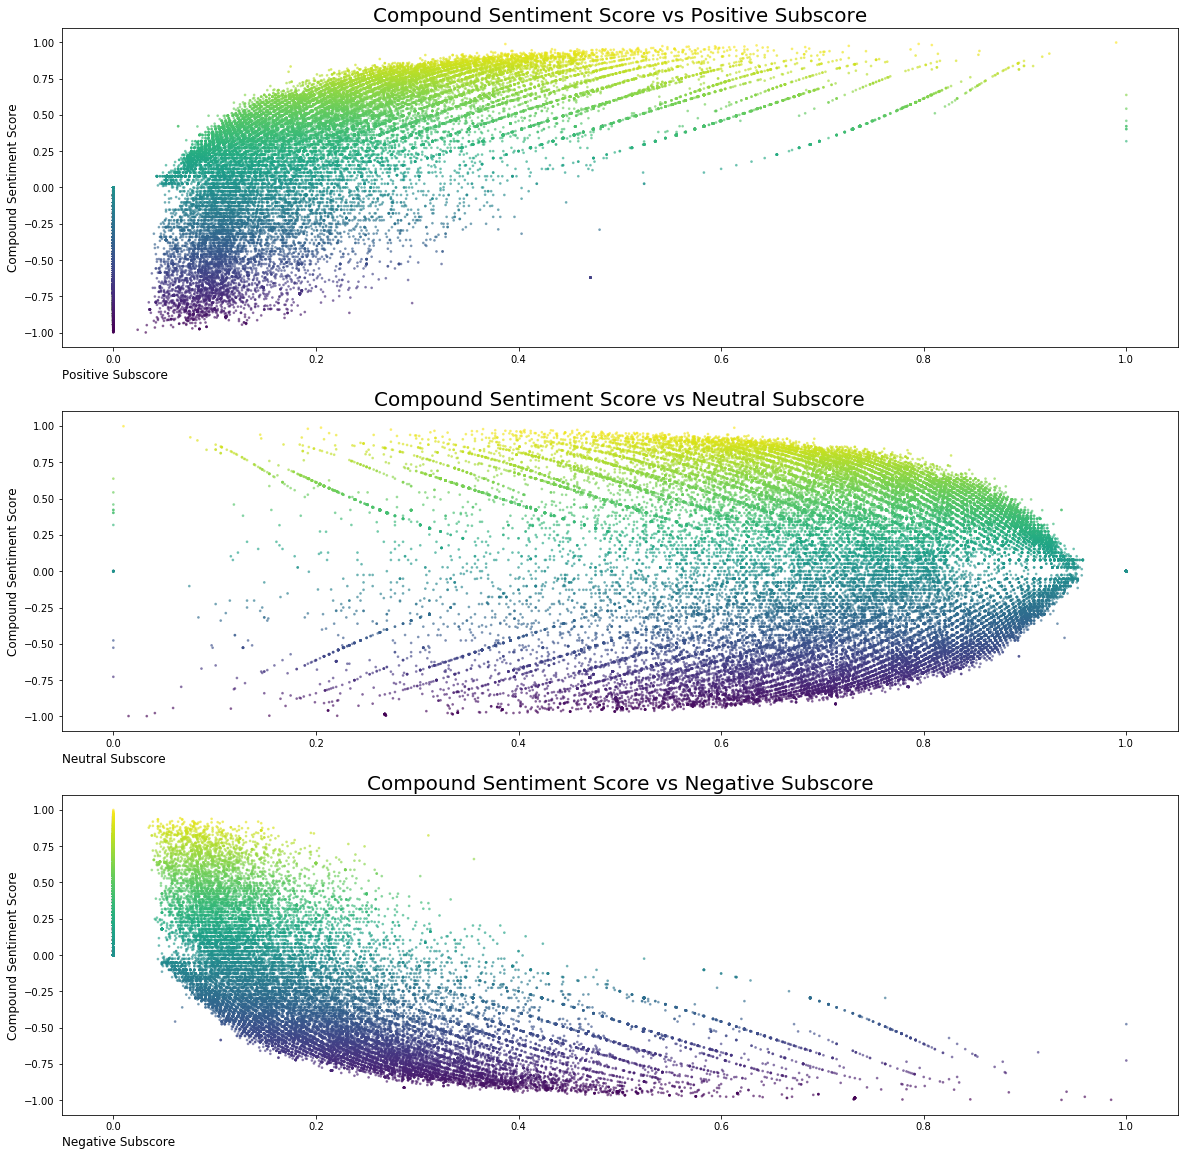

In [184]:
from matplotlib.transforms import Bbox, TransformedBbox, \
    blended_transform_factory

plt.figure(figsize=(20,20)) #set sixe of figure

# Compound Score versus positive score
x1 = features_scores['pos']
y1 = features_scores['compound']
colors1 = features_scores['compound']
area1 = (3)  # 0 to 15 point radii

#define subplot
plt.subplot(3, 1, 1)
plt.scatter(x1, y1, s=area1, c=colors1, alpha=0.5)

# Add title and axis names
plt.title('Compound Sentiment Score vs Positive Subscore',fontsize=20)
plt.xlabel('Positive Subscore',fontsize=12,horizontalalignment='left',x=0.0)
plt.ylabel('Compound Sentiment Score',fontsize=12)

#Compound Score versus neutral score
x2 = features_scores['neu']
y2 = features_scores['compound']
colors2 = features_scores['compound']
area2 = (3) #arbitrary value to make trends easy to see

plt.subplot(3, 1, 2)
plt.scatter(x2, y2, s=area2, c=colors2, alpha=0.5)

# Add title and axis names and adjust fontsize
plt.title('Compound Sentiment Score vs Neutral Subscore',fontsize=20)
plt.xlabel('Neutral Subscore',fontsize=12,horizontalalignment='left',x=0.0)
plt.ylabel('Compound Sentiment Score',fontsize=12)

#Compound Score versus negative score
x3 = features_scores['neg']
y3 = features_scores['compound']
colors3 = features_scores['compound']
area3 = (3)  # 0 to 15 point radii

plt.subplot(3, 1, 3)
plt.scatter(x3, y3, s=area3, c=colors3, alpha=0.5)

# Add title and axis names
plt.title('Compound Sentiment Score vs Negative Subscore',fontsize=20)
plt.xlabel('Negative Subscore',fontsize=12,horizontalalignment='left',x=0.0)
plt.ylabel('Compound Sentiment Score',fontsize=12)

plt.show()

In the plots above, patterns in the `VADER` assignment of sentiment score become obvious. As described before, positive and compound scores are directly proportional, while negative and compound scores are indirectly proportional. The middle plot shows the mixed effect of comparing compound scores to neutral scores.

Sentiment seems fairly evenly distributed, with few tweets at the extreme ranges of negative and positive scores. There are tweets that received zero as a positive or negative score that form a vertical line in the top and bottom plots, respectively. 

### Term frequency: Dataset 1

To discover the terms most tweeted among @mikegravel's followers, frequency of each word is calculated. We'll then combine these data with sentiment scores to detect the sentiment context of the most frequent terms in our sample.  

Words of 2 characters or less are omitted, and words appearing less frequently than 100 times in our sample are omitted.

In [185]:
# calculate frequency by word
word_freq = pd.DataFrame(features_scores.tweet_text.str.split(expand=True).stack().value_counts())

#reset index, rename columns, format
word_freq.reset_index(level=0, inplace=True)
word_freq.columns = ['word','frequency']
word_freq['frequency'] = word_freq['frequency'].apply(pd.to_numeric)

#filter out words of less than two characters in length.
word_freq2 = word_freq[word_freq['word'].apply(lambda x: len(x) > 2)]

#filter words that appear less frequently than 100 times in the tweets
word_freq3 = word_freq2[word_freq2.frequency > 100]

#view result
word_freq3.head(10)

word  frequency
0    the      35681
4    and      15823
8    you      10670
9    for      10505
10  that       9139
11  this       8148
13   are       6709
15  with       5654
16   The       5396
19  have       4774

Words are converted to lowercase and stopwords removed.

In [186]:
pd.options.mode.chained_assignment = None  # default='warn'

#load stopwords
from nltk.corpus import stopwords 
stop = stopwords.words('english')

#convert to lowercase
word_freq3['word'] = word_freq3['word'].str.lower()

#remove stopwords
word_freq4 = word_freq3[~word_freq3['word'].isin(stop)]

#view result
word_freq4.head(10)

word  frequency
24    like       3652
31  people       3356
48    iran       2441
50     one       2414
54   trump       2186
57    dont       2099
59   would       2046
66   think       1845
67    know       1843
69     get       1796

In order to capture the most salient terms and topic identities, the most frequent words are filtered below. This operation exposes the specific topics in the resulting dataframe. These 50 terms will form the foundation for further analysis.

What is the collective sentiment of tweets containing these terms in our sample?

In [187]:
remove = ['like','people','one','would','get','see','know','think','make',
          'good','going','need','new','say','never','really','want','got','right',
         'cant','youre','years','love','said','trying','first','man','day','still','even',
         'take','back','ever','ive','im','also','could','every','many','better','made','says',
         'today','doesnt','way','much','time','today','year','shit','best','fucking','thing','it.',
         'someone','didnt','old','via','look','next','world','anyone','show','put','real','really','since',
         'isnt','he','she','hes','tweet','feel','tell','dont','last','work','thats','great','actually',
         'stop','video','always','call','two','things','learn','thank','theyre','called','use',
         'http','read','sure','life','gonna','bad','give','start','guy','come','please','fuck','everyone',
         'keep','getting','end','million','without','person','saying','another','must','makes',
         'something','talk','live','state','something.','week','working','ill','big','lot','well',
         'making','taking','pretty','around','name','long','let','free','remember','mean','watch',
         'using','literally','hey','thought','believe','ago','least','told','story','woman','change',
         'needs','win','part','help','game','news','vote','little','may','find','happy','nothing','public',
         'guys','human','away','enough','hope','support','pay','care','used','understand','wont','wants',
         'moment','yes','single','seen','hear','top','age','wrong','anything','twitter','history',
         'night','lol','point','done','job','die','money','hard','cool']

word_freq5 = word_freq4[~word_freq4['word'].isin(remove)]

word_freq5.head(50)

word  frequency
48               iran       2441
54              trump       2186
73                war       1699
87     @berniesanders       1341
95               @aoc       1223
119            bernie        989
121  @realdonaldtrump        981
133       @mikegravel        909
141             biden        865
155             camps        796
161           country        753
164     concentration        729
171          children        705
173            school        694
177          american        674
189              iraq        615
210               joe        553
216               war        541
226             media        522
232           america        515
233             white        514
249         president        485
268           sanders        457
271              kids        454
274             drone        448
277            police        439
284            warren        430
295             women        419
304        juneteenth        412
306         president        409
311               men        391
317             black        387
328        government        374
331           climate        373
337          @ilhanmn        369
338    @thejalatucker        369
344          @ewarren        360
346               ice        359
355          campaign        353
361            united        351
363        democratic        349
364          military        347
368              left        342
374    administration        339
383            rights        332
393             black        327
398             party        321
399            racist        321
400         americans        320
407     @tulsigabbard        313

### Plotting term frequency: Dataset 1

The frequency of 50 of the most frequency terms is plotted below.

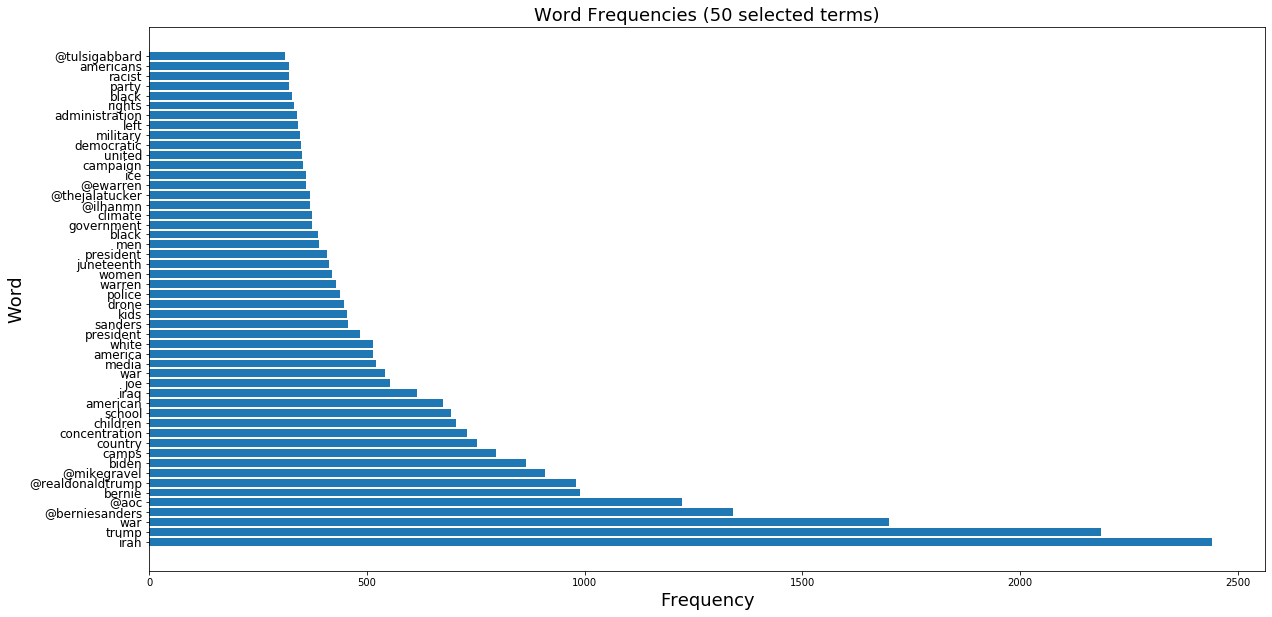

In [188]:
plt.figure(figsize=(20,10))
# this is for plotting purpose
index = np.arange(len(word_freq5['word'][:50]))
plt.barh(index, word_freq5['frequency'][:50])
plt.ylabel('Word', fontsize=18)
plt.xlabel('Frequency', fontsize=18)
plt.yticks(index, word_freq5['word'][:50], fontsize=12, rotation=0)
plt.title('Word Frequencies (50 selected terms)',fontsize=18)
plt.show()
    

These terms are concatenated into a list, then compared with tweet_text in our sentiment dataframe; the result is a sorted dataframe containing the tweets containing at least one of our chosen terms.

In [189]:
terms = list(word_freq5['word'][:50])
terms_conc = ' | '.join(terms)
print(terms_conc)

iran | trump | war | @berniesanders | @aoc | bernie | @realdonaldtrump | @mikegravel | biden | camps | country | concentration | children | school | american | iraq | joe | war | media | america | white | president | sanders | kids | drone | police | warren | women | juneteenth | president | men | black | government | climate | @ilhanmn | @thejalatucker | @ewarren | ice | campaign | united | democratic | military | left | administration | rights | black | party | racist | americans | @tulsigabbard


In [190]:
features_scores_terms = features_scores[features_scores['tweet_text'].str.contains(terms_conc)==True]

features_scores_terms.head(10)

tweet_text  \
27957  @ChandlerrAllenn  Black women are beautiful Black women are beautiful Black women are beautiful Black women are beau...   
82014  @RafiDAngelo  Buttigeig  Im a basic white guy candidate BUT GAY  Biden  I was your favorite Presidents best friend  ...   
64776                            Only a couple of hick ups tonight 🤭 other wise left feeling blessed by those who support me ✨   
52730  @KaitMarieox  Happy flag day and happy birthday to the best president in US history @realDonaldTrump 🇺🇸   //tco/1yY7...   
41868  @MikeGravel Awesome! Keep me posted ;) Good luck on your campaign hopefully you get to the point that Mike enters   ...   
18132  @RaceSexPolitics  I feel like I should make this pretty clear  I dont hate black men and I dont hate white people I ...   
70679  Lmao Good luck to all the parents that named their kids Khaleesi oe Daenarys lmao hahahahhahaahaha yall might as   /...   
11818  @OurFutureNow_  Hey @ukhomeoffice 👋 Nice new ad campaign you have today plastered all over London Underground Honest...   
59531  @OurFutureNow_  Hey @ukhomeoffice 👋 Nice new ad campaign you have today plastered all over London Underground Honest...   
45234  @OurFutureNow_  Hey @ukhomeoffice 👋 Nice new ad campaign you have today plastered all over London Underground Honest...   

       neg    neu    pos  compound  
27957  0.0  0.506  0.494    0.9485  
82014  0.0  0.515  0.485    0.9442  
64776  0.0  0.489  0.511    0.9403  
52730  0.0  0.493  0.507    0.9371  
41868  0.0  0.518  0.482    0.9312  
18132  0.0  0.503  0.497    0.9306  
70679  0.0  0.539  0.461    0.9287  
11818  0.0  0.573  0.427    0.9246  
59531  0.0  0.573  0.427    0.9246  
45234  0.0  0.573  0.427    0.9246

In [191]:
features_scores_terms.tail(10)

tweet_text  \
75361  @pblest  Now is the time to say no No war no war no war no war no matter how much a few middle-aged men in suits who...   
64964  @pblest  Now is the time to say no No war no war no war no war no matter how much a few middle-aged men in suits who...   
68306  @pblest  Now is the time to say no No war no war no war no war no matter how much a few middle-aged men in suits who...   
43451  @pblest  Now is the time to say no No war no war no war no war no matter how much a few middle-aged men in suits who...   
13780  @pblest  Now is the time to say no No war no war no war no war no matter how much a few middle-aged men in suits who...   
45075  @davidcicilline  This is no campaign rally Its a hate rally   Hate the media Hate immigrants Hate Hillary Hate Democ...   
76529  @ancombigirlgnat  Fuck white CEOs Fuck Black CEOs Fuck Asian CEOs Fuck Hispanic CEOs Fuck Women CEOs Fuck Jewish CEO...   
21349  Now is the time to say no No war no war no war no war no matter how much a few middle-aged men in suits who w   //tc...   
70169  @peterdaou  A war on migrants  A war on women  A war on people of color  A war on the poor  A war on the sick  A war...   
47264  @peterdaou  A war on migrants  A war on women  A war on people of color  A war on the poor  A war on the sick  A war...   

         neg    neu    pos  compound  
75361  0.575  0.340  0.085   -0.9737  
64964  0.575  0.340  0.085   -0.9737  
68306  0.575  0.340  0.085   -0.9737  
43451  0.575  0.340  0.085   -0.9737  
13780  0.575  0.340  0.085   -0.9737  
45075  0.670  0.330  0.000   -0.9761  
76529  0.605  0.395  0.000   -0.9764  
21349  0.641  0.334  0.024   -0.9792  
70169  0.665  0.335  0.000   -0.9846  
47264  0.665  0.335  0.000   -0.9846

In [192]:
features_scores_terms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10263 entries, 27957 to 47264
Data columns (total 5 columns):
tweet_text    10263 non-null object
neg           10263 non-null float64
neu           10263 non-null float64
pos           10263 non-null float64
compound      10263 non-null float64
dtypes: float64(4), object(1)
memory usage: 481.1+ KB


In [193]:
print(features_scores_terms.tweet_text[45234])

@OurFutureNow_  Hey @ukhomeoffice 👋 Nice new ad campaign you have today plastered all over London Underground Honesty is the best pol


Above we see the tweets sorted by sentiment, each containing at least one of our chosen words. This process allows us to examine the sentiment of the tweet that contained them. By focusing on tweets that include our selected terms we have created a subset of 10,263 tweets, roughly 12% of our original sample.

Below we plot the sentiment distribution of these tweets.

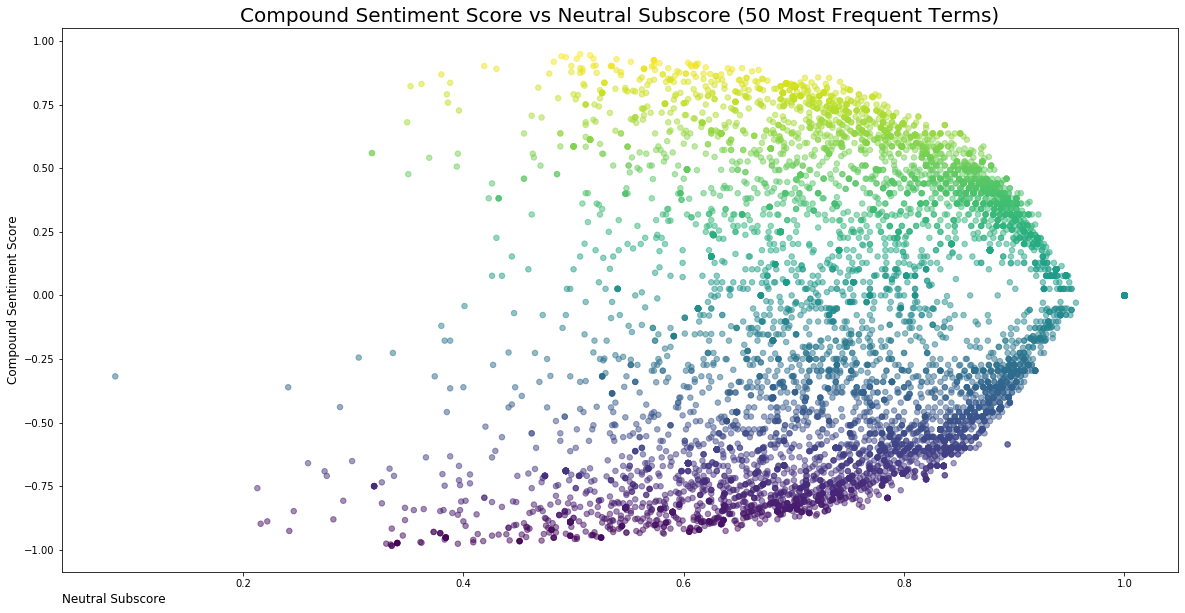

In [194]:
plt.figure(figsize=(20,10))

x = features_scores_terms['neu']
y = features_scores_terms['compound']
colors = features_scores_terms['compound']
area = (30) 

plt.scatter(x, y, s=area, c=colors, alpha=0.5)

# Add title and axis names
plt.title('Compound Sentiment Score vs Neutral Subscore (50 Most Frequent Terms)',fontsize=20)
plt.xlabel('Neutral Subscore',fontsize=12,horizontalalignment='left',x=0.0)
plt.ylabel('Compound Sentiment Score',fontsize=12)

plt.show()

Among our selected subset of tweets it appears that sentiment is slightly negative overall. Let's calculate the mean compound score to confirm.

In [195]:
features_scores_terms2 = features_scores[features_scores['tweet_text'].str.contains(terms_conc)==True]['compound'].mean()

features_scores_terms2

-0.09503590568060184

A mean compound score of -0.095 indicates a generally neutral, slightly negative sentiment in our selected tweets.

Let's plot the mean sentiment scores (positive, neutral, negative, and compound) of each of our selected terms with an indication of frequency of the occurrence in our overall sample.

In [196]:
#calculate means for each subscore
sent_means = []
for x in terms:
    sent_means_neg = features_scores[features_scores['tweet_text'].str.contains(x)==True]['neg'].mean()
    sent_means_neu = features_scores[features_scores['tweet_text'].str.contains(x)==True]['neu'].mean()
    sent_means_pos = features_scores[features_scores['tweet_text'].str.contains(x)==True]['pos'].mean()
    sent_means_comp = features_scores[features_scores['tweet_text'].str.contains(x)==True]['compound'].mean()
    item = [x,sent_means_neg,sent_means_neu,sent_means_pos,sent_means_comp]
    sent_means.append(item)

In [197]:
sentiment_means = pd.DataFrame(sent_means,columns=['word','neg','neu','pos','compound'])

sentiment_means.head(5)

word       neg       neu       pos  compound
0            iran  0.207676  0.702549  0.089782 -0.342071
1           trump  0.111187  0.794339  0.094479 -0.036823
2             war  0.170417  0.736249  0.093327 -0.226174
3  @berniesanders  0.000000  0.682000  0.318000  0.753100
4            @aoc  0.062333  0.819333  0.118333  0.163607

Now that mean scores are calculated we can merge with word frequency data. The resulting dataframe of our 50 terms is sorted by compound score and displayed.

In [198]:
#reset the index
WF50 = word_freq5.reset_index(drop=True)

#preliminary data cleaning
WF50.columns = WF50.columns.str.replace(' ', '')
sentiment_means.columns = sentiment_means.columns.str.replace(' ', '')

#combine duplicate terms in our original frequency dataframe and find sum of frequencies among them
WF50 = WF50.groupby('word').apply(lambda x: pd.Series(dict(frequency=(x.frequency.sum()))))

#prepare for merge
left = WF50
right = sentiment_means

#merge
SMF = pd.merge(left,right,on='word')
SMF = SMF.dropna()
SMF = SMF.drop_duplicates()

#sort by compound score
SMF = SMF.sort_values('compound',ascending=False)

SMF.head(50)

word  frequency       neg       neu       pos  compound
1     @berniesanders       1341  0.000000  0.682000  0.318000  0.753100
44            united        351  0.059324  0.738529  0.202147  0.316212
35             party        553  0.083856  0.722390  0.193771  0.255729
0               @aoc       1223  0.062333  0.819333  0.118333  0.163607
16          campaign        353  0.050125  0.839843  0.110039  0.159300
12            bernie        989  0.068522  0.821051  0.110434  0.127748
41           sanders        457  0.044489  0.843766  0.111745  0.104253
25               ice        359  0.076151  0.802457  0.121403  0.081867
29        juneteenth        412  0.138800  0.675333  0.185867  0.075560
40            rights        332  0.056344  0.849589  0.094064  0.072552
48             white        734  0.090952  0.799705  0.109399  0.041827
28               joe        553  0.070795  0.845037  0.084172  0.030866
27              iraq        615  0.124625  0.750625  0.124625  0.027600
22        democratic        349  0.052855  0.891040  0.056097  0.017552
47            warren        430  0.100597  0.797271  0.102130  0.008408
9            america        515  0.089547  0.812156  0.098273  0.007931
31              left        342  0.076829  0.833074  0.090093  0.004994
6     @thejalatucker        369  0.000000  1.000000  0.000000  0.000000
4        @mikegravel        909  0.000000  1.000000  0.000000  0.000000
42            school        694  0.040264  0.920168  0.039574 -0.002208
30              kids        454  0.089051  0.827220  0.083705 -0.011641
8     administration        339  0.102289  0.798480  0.099183 -0.012513
33               men        391  0.091832  0.816379  0.091785 -0.015574
2           @ewarren        360  0.100315  0.802501  0.097181 -0.017153
20     concentration        860  0.074941  0.850156  0.074908 -0.019181
13             biden        865  0.080537  0.847418  0.072060 -0.020185
37         president        894  0.089187  0.832373  0.078449 -0.036472
43             trump       2320  0.111187  0.794339  0.094479 -0.036823
49             women        419  0.105220  0.800987  0.093797 -0.041105
23             drone        448  0.097224  0.831052  0.071657 -0.046631
10          american        674  0.106759  0.800190  0.093013 -0.047787
36            police        439  0.090391  0.839010  0.070624 -0.063874
17             camps        796  0.084883  0.848299  0.066823 -0.069779
19           climate        373  0.099582  0.820399  0.080084 -0.073201
34          military        347  0.111134  0.815365  0.073436 -0.084857
14             black        714  0.104825  0.808865  0.086294 -0.089945
18          children        705  0.109722  0.817633  0.072630 -0.129221
21           country        753  0.099182  0.836040  0.064765 -0.141373
24        government        374  0.119613  0.810091  0.070294 -0.142867
32             media        522  0.113575  0.811622  0.074795 -0.146120
11         americans        320  0.126294  0.818882  0.054706 -0.151871
5   @realdonaldtrump        981  0.144667  0.831500  0.023833 -0.218667
45               war       2240  0.170417  0.736249  0.093327 -0.226174
26              iran       2441  0.207676  0.702549  0.089782 -0.342071
39            racist        321  0.242812  0.643232  0.114034 -0.374721

The term '@berniesanders' is included in tweets with the highest mean compound sentiment scores, while the word 'racist' is our most negatively-associated term in tweets with the lowest mean sentiment. Most tweets containing our chosen terms are relatively neutral in compound sentiment scores.

In [234]:
SMF['compound'].mean()

-0.006953488288671197

The overall mean compound sentiment of the tweets which contain our terms is approximately neutral at -0.01.

Let's plot the results.

Below, plots of compound sentiment mean scores indicate the terms used in the most positive and negative tweets. The plots are enlarged and separated to enhance visibility. Frequency is indicated by size of each plotted point. Higher mean sentiment is indicated by a yellow hue while lower mean sentiment is indicated by purple.

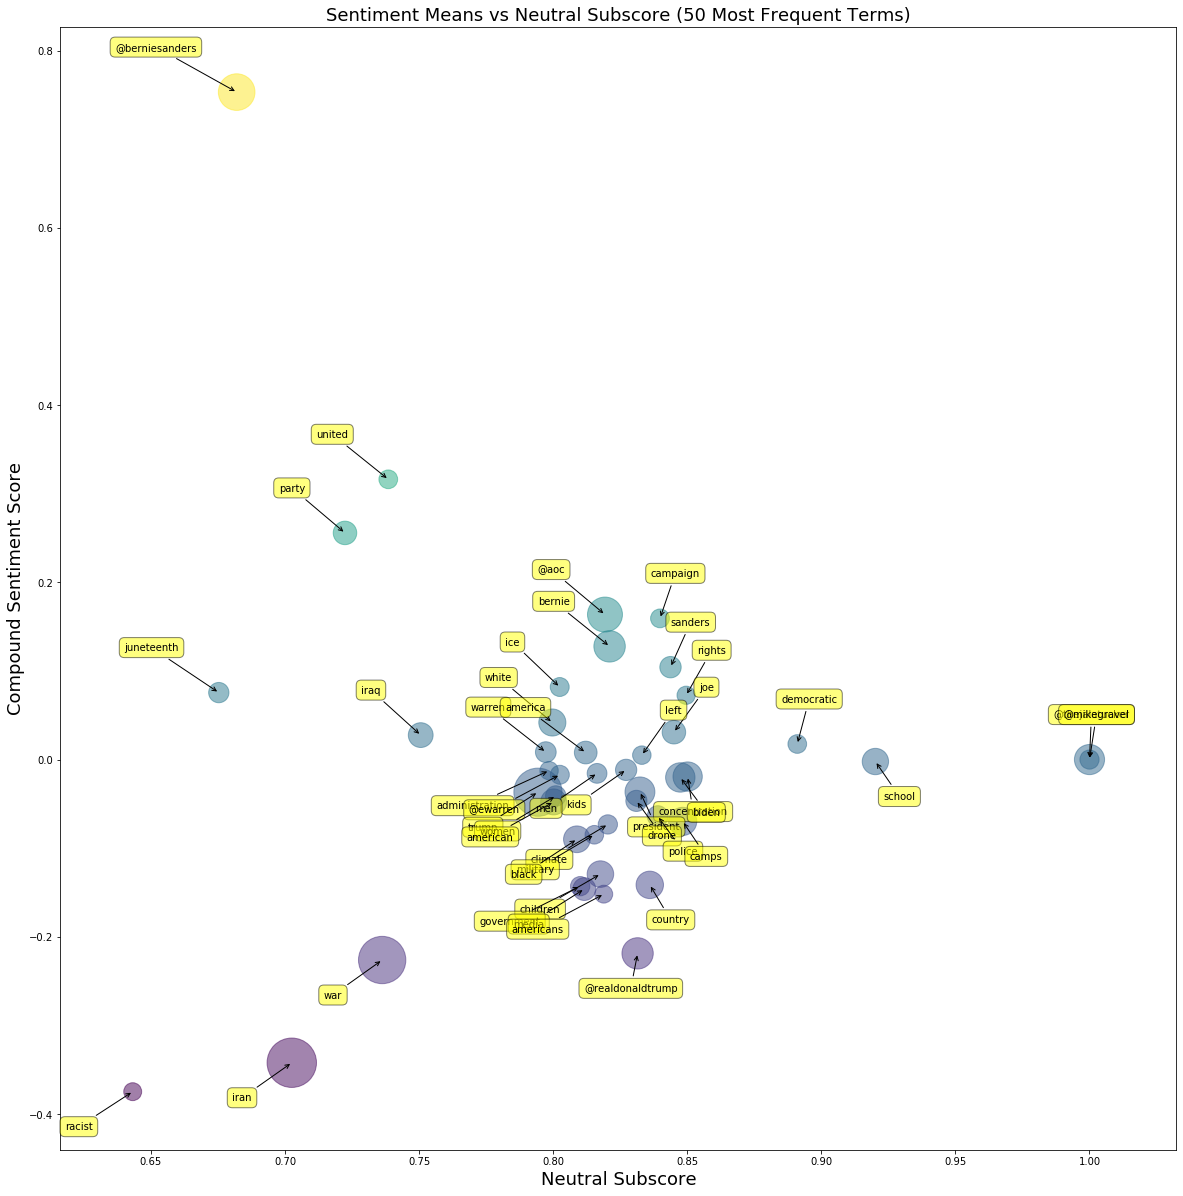

In [199]:
plt.figure(figsize=(20,20))

x = SMF['neu']
y = SMF['compound']
colors = SMF['compound']
area = (SMF['frequency']) 

labels = [i for i in SMF['word']]
plt.subplots_adjust(bottom = 0.1)

plt.scatter(x, y, s=area, c=colors, alpha=0.5)

# Add title and axis names
plt.title('Sentiment Means vs Neutral Subscore (50 Most Frequent Terms)',fontsize=18)
plt.xlabel('Neutral Subscore',fontsize=18)
plt.ylabel('Compound Sentiment Score',fontsize=18)

for label, x, y in zip(labels, SMF['neu'], SMF['compound']):
    flip = 2
    if x < .83: flip = -2
        
    flop = 2
    if y < 0: flop = -2
    plt.annotate(
        label,
        xy=(x, y), xytext=(20*flip, 20*flop),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.show()

The twitter handle of Bernie Sanders appears in the most positive, least neutral tweets, while his name is mentioned in marginally positive and relatively neutral tweets toward the center. 'Iran' is mentioned frequently in negative tweets, though the mean neutrality of those tweets is fairly high. 'Iran' and 'war' are closely related; this sample was drawn while conflict with Iran was widely reported in the news and the administration seemed to be provoking a conflict. Additionally, 'Iran' and 'war' topped our frequency list, as seen earlier in this analysis. 'Juneteenth', 'democratic', and 'school' were included in marginally positive tweets of varying degrees of neutrality. 

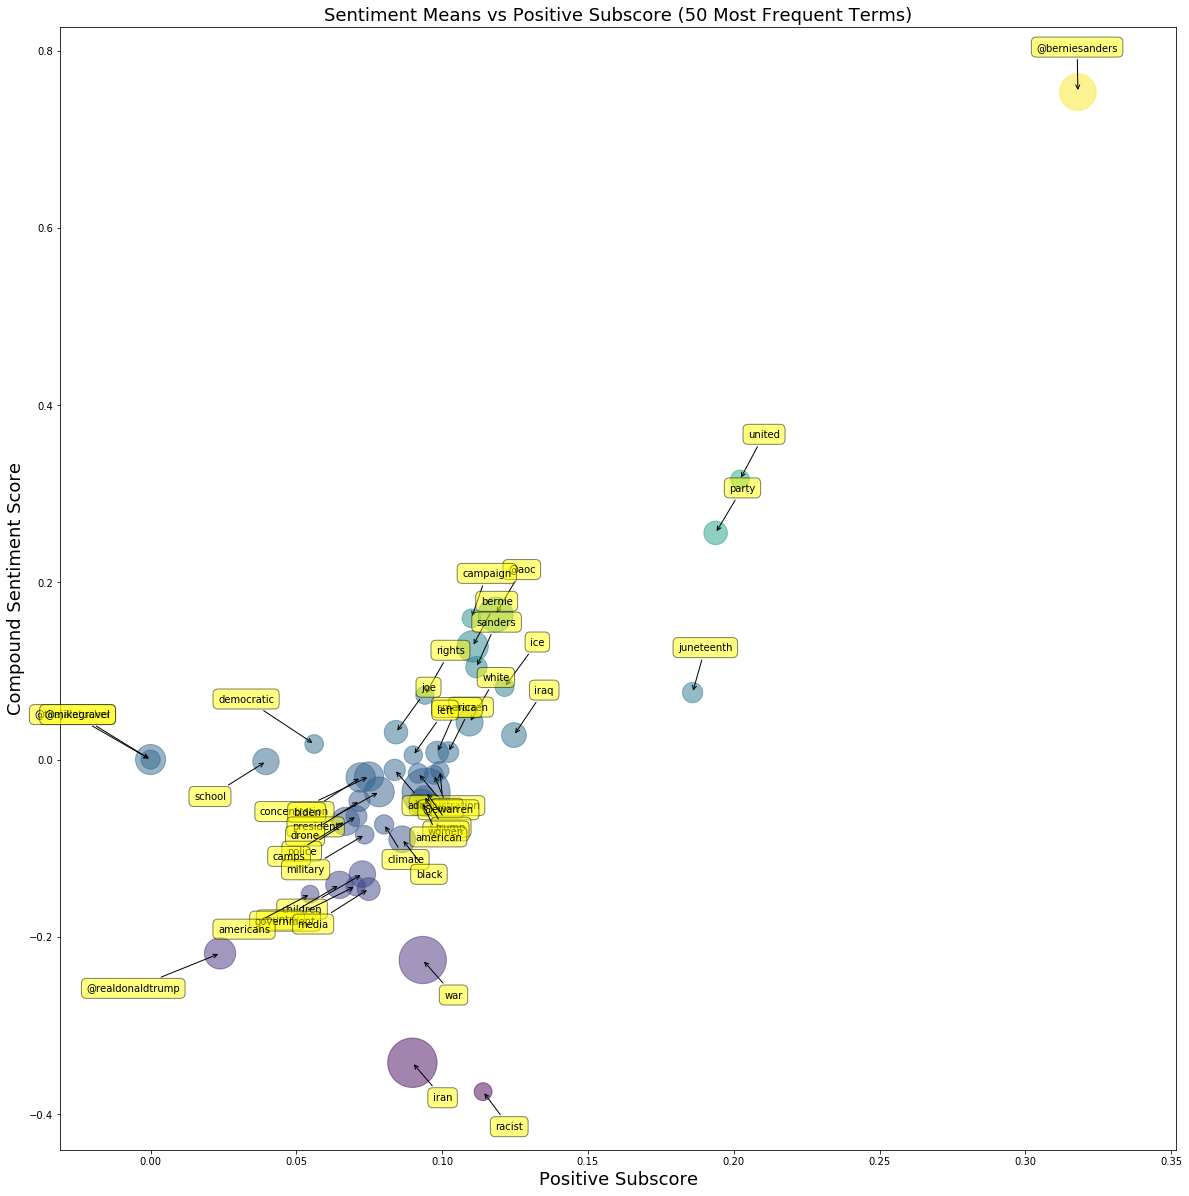

In [200]:
plt.figure(figsize=(20,20))

x = SMF['pos']
y = SMF['compound']
colors = SMF['compound']
area = (SMF['frequency']) 

labels = [i for i in SMF['word']]
plt.subplots_adjust(bottom = 0.1)

plt.scatter(x, y, s=area, c=colors, alpha=0.5)

# Add title and axis names
plt.title('Sentiment Means vs Positive Subscore (50 Most Frequent Terms)',fontsize=18)
plt.xlabel('Positive Subscore',fontsize=18)
plt.ylabel('Compound Sentiment Score',fontsize=18)

for label, x, y in zip(labels, SMF['pos'], SMF['compound']):
    flip = 2
    if x < .08: flip = -2
        
    flop = 2
    if y < 0: flop = -2
    plt.annotate(
        label,
        xy=(x, y), xytext=(20*flip, 20*flop),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.show()

Plotting compound mean scores against positive mean score shifts things around a bit; '@berniesanders' still among the most frequently used terms in positive tweets, with 'war' and 'Iran' in more negative terms. This alignment exposes '@realdonaldtrump' as frequently mentioned with marginally negative sentiment. '@aoc' peeks out from behind the cluster in the center as marginally positive. As before, we see that most tweets containing the most frequent terms are close to a 0 compound score. 

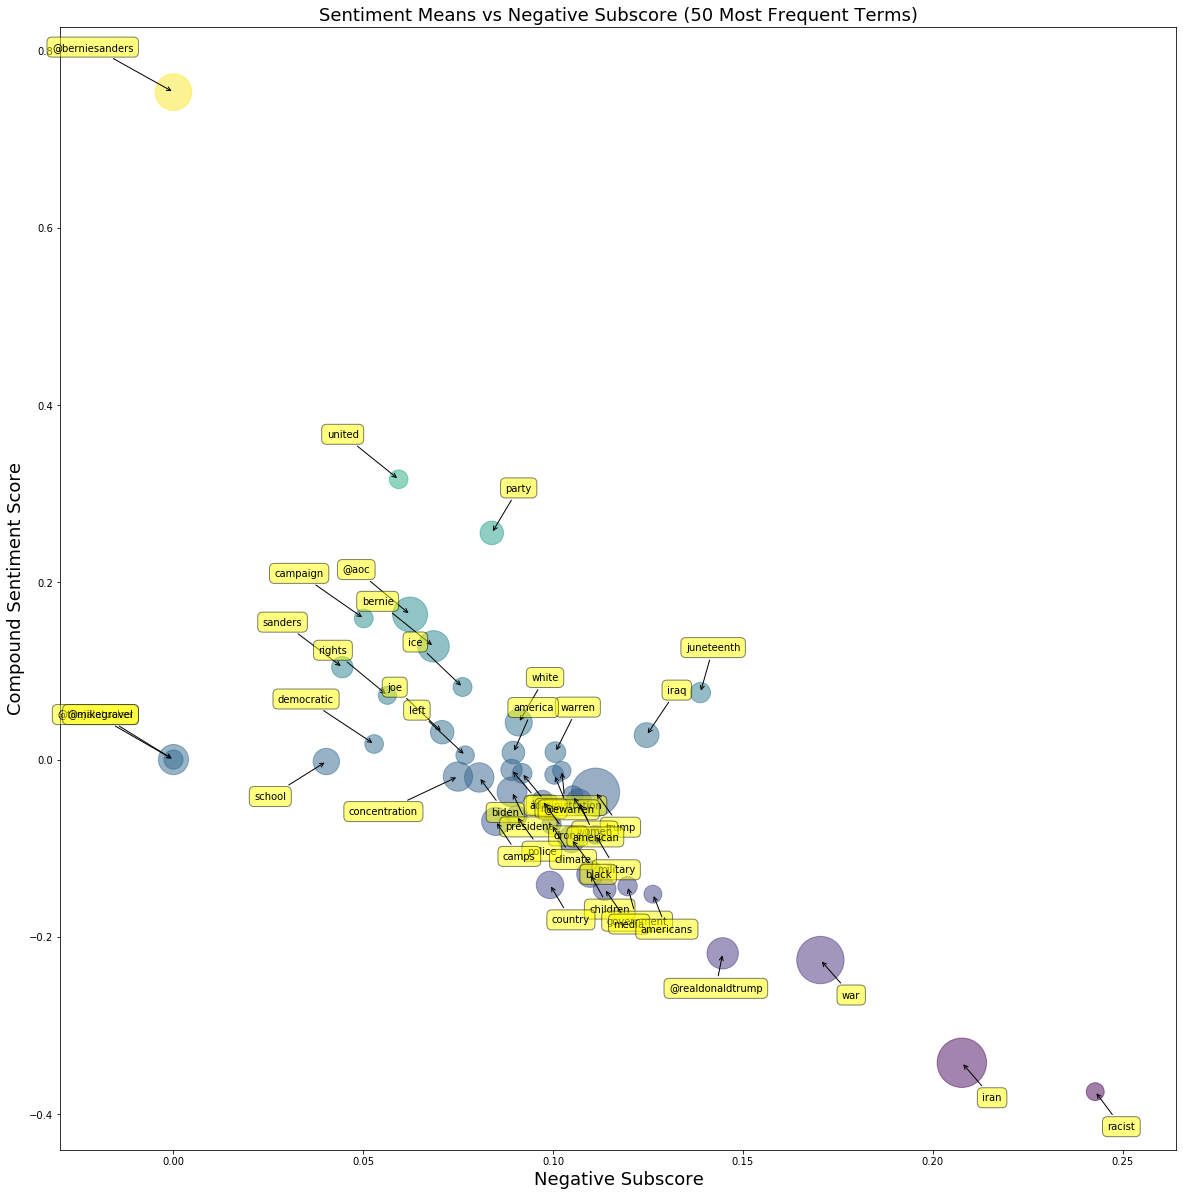

In [201]:
plt.figure(figsize=(20,20))

x = SMF['neg']
y = SMF['compound']
colors = SMF['compound']
area = (SMF['frequency']) 

labels = [i for i in SMF['word']]
plt.subplots_adjust(bottom = 0.1)

plt.scatter(x, y, s=area, c=colors, alpha=0.5)

# Add title and axis names
plt.title('Sentiment Means vs Negative Subscore (50 Most Frequent Terms)',fontsize=18)
plt.xlabel('Negative Subscore',fontsize=18)
plt.ylabel('Compound Sentiment Score',fontsize=18)

for label, x, y in zip(labels, SMF['neg'], SMF['compound']):
    flip = 2
    if x < .08: flip = -2
        
    flop = 2
    if y < 0: flop = -2
    plt.annotate(
        label,
        xy=(x, y), xytext=(20*flip, 20*flop),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.show()

Lurking in the midst of the centered cluster is one of our most-frequently tweeted terms: 'trump'. Sentiment for the tweets containing this term are surprisingly marginally negative and centered at a 0 compound score. While many of followers of @mikegravel are likely liberal, the marginal negativity of tweets mentioning trump is likely due to the specific context of each tweet; one might compliment a democrat or politician that combats trump effectively in language that earns a neutral compound score.

## Dataset 2: follower tweets of 07/13/2019  

This dataset draws a sample of tweets after two democratic debates took place, the concentration camp backlash subsided and war with Iran has been overshadowed by a controversial comment uttered by Biden in a clumsy attempt to explain his history of bipartisanship. Reports of assault on migrants in detainment have dominated the news.

In [202]:
with urllib.request.urlopen("https://raw.githubusercontent.com/aliceafriedman/team6_final/master/mikegravel1562978529.995827_followers.json") as url:
    gravel2 = pd.read_json(url.read().decode())

gravel2.head()

screen_name  verified           location  followers_count  \
0       HookupsJZA     False          Depew, NY             1048   
1       mollyb3797     False                                  45   
2      juliaafoley     False      New York, USA              409   
3  ProgressiveinMN     False  Western Minnesota               15   
4      nicolelucht     False      washington dc              510   

                                                                                                                tweet_text  \
0                                                                      @MaxBlumenthal @ComradeCalifor1 Damn that's strong!   
1  RT @emrazz: A 15 year old migrant child described the laughter of the CBP officer as he assaulted and humiliated her...   
2                                I think I might donate. I wanna see this guy on the debate stage! https://t.co/qTSkUXSBQT   
3  @RashidaTlaib @OurRevolution We live in the richest country in the world. It is about time that we make our politic…...   
4                                                                                                                     None   

   retweet_count  favorite_count  
0            0.0             1.0  
1          569.0             0.0  
2            0.0             0.0  
3            0.0             1.0  
4            NaN             NaN

In [203]:
gravel2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118389 entries, 0 to 118388
Data columns (total 7 columns):
screen_name        118389 non-null object
verified           118389 non-null bool
location           118389 non-null object
followers_count    118389 non-null int64
tweet_text         103386 non-null object
retweet_count      103386 non-null float64
favorite_count     103386 non-null float64
dtypes: bool(1), float64(2), int64(1), object(3)
memory usage: 5.5+ MB


There 103,386 tweet texts in our second sample.

In [204]:
features20 = gravel2.iloc[:, 4].values 

#remove rows with no tweet text to analyze
features20 = [x for x in features20 if x is not None]

features20 = [re.sub(r'[\n]', ' ', x) for x in features20] #remove \m line breaks
features20 = [re.sub(r'&amp;', ' ', x) for x in features20] #remove ampersand trash code
features20 = [re.sub(r':', ' ', x) for x in features20] #remove colons that appear after retweet mentions
features20 = [re.sub(r'https', ' ', x) for x in features20] #remove https as a word, resulting from above
features20 = [re.sub(r"[\"\'’….,]", '', x) for x in features20] #remove many special characters, including special apostrophe
features20 = [re.sub(r"^RT ", '', x) for x in features20] #remove RT (retweet symbol)

#keep a copy of the original set for reference and troubleshooting
scores20 = features20

#make a dataframe for use later.
features21 = pd.DataFrame(features20)
features21.columns = ['tweet_text']


i=0
for feature in scores20:
    vs = analyzer.polarity_scores(feature)
    scores20[i] = ("{}".format(str(vs)))
    i+=1
    
scores21 = pd.DataFrame(scores20)
scores21.columns = ['scores']
scores21['scores'] = scores21['scores'].astype(str)

f = lambda x: x["scores"].split("'neg': ")[1].split(",")[0]
scores21['neg']  = scores21.apply(f, axis=1)

f = lambda x: x["scores"].split("'neu': ")[1].split(",")[0]
scores21['neu']  = scores21.apply(f, axis=1)

f = lambda x: x["scores"].split("'pos': ")[1].split(",")[0]
scores21['pos']  = scores21.apply(f, axis=1)

f = lambda x: x["scores"].split("'compound': ")[1].split("}")[0]
scores21['compound']  = scores21.apply(f, axis=1)

scores21 = scores21.drop("scores", axis = 1)

scores21.head(5)


neg    neu    pos compound
0  0.291  0.323  0.387   0.2244
1  0.193    0.7  0.107  -0.3818
2    0.0    1.0    0.0      0.0
3    0.0  0.855  0.145   0.5267
4  0.232  0.768    0.0  -0.4973

### The most positive and most negative tweets, according to `VADER`: Dataset 2  

Following the same process as detailed above we rank the tweets by compound sentiment score.

In [205]:
features_scores20 = features21.join(scores21) #merge

#convert to numeric for sorting
features_scores20[['pos','neg','neu','compound']] = features_scores20[['pos','neg','neu','compound']].apply(pd.to_numeric)

#sort the dataframe
features_scores20 = features_scores20.sort_values('compound',ascending=False)

#expand the display of the column
pd.options.display.max_colwidth = 120
features_scores20.head(10)

tweet_text  \
52758   @liamgallagher  Ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha h...   
73996   @jude_boiled  @holygrailshawty oh yeah woo oh yeah woo yeah woo yeah oh yeah oh woo yeah woo yeah woo yeah woo time ...   
1544           @united Please dont kill me! Please dont kill me! Please dont kill me! Please dont kill me! Please dont kill me!   
2165    @tinybuddha  I am an old soul I love genuine kindness I love compassion I love poetry I love soul connection I love ...   
13957   @ericsshadow  PROGRESSIVES  are you with us?  NANCY PELOSI    yesyes      yes     yes yes yes yes yes     yes     ye...   
102351  YOGA BEAUTY SECRETS - INSPIRE by Melinda shears  Love inspires creativity within us creating goodness http //tco/iCB...   
16208                 Congrats Ty you amazing loving accomplished woman!!!! WE LOVE UUUUUU! #congratagradNYU   //tco/jrIg8knW4N   
57375                              @TheView @MeghanMcCain @robbysoave LMAO taking time off to enjoy great reads SO FUNNY hahaha   
35781   @MomHeffley  WE LIKE FORTNITE WE LIKE FORTNITE  WE LIKE FORTNITE WE LIKE FORTNITE WE WE LIKE FORTNITE WE LIKE FORTNI...   
77041   @anotherworld010  A day full of love smiles  peace happiness and lots of other amazing moments to everyone💕💗💕 Enjoy ...   

        neg    neu    pos  compound  
52758   0.0  0.010  0.990    0.9976  
73996   0.0  0.125  0.875    0.9918  
1544    0.0  0.260  0.740    0.9840  
2165    0.0  0.308  0.692    0.9818  
13957   0.0  0.270  0.730    0.9750  
102351  0.0  0.274  0.726    0.9746  
16208   0.0  0.209  0.791    0.9741  
57375   0.0  0.298  0.702    0.9725  
35781   0.0  0.414  0.586    0.9706  
77041   0.0  0.395  0.605    0.9698

In [206]:
features_scores20.tail(10)

tweet_text  \
84387  @Joe_Schmucc  These cops are trigger happy for unarmed black kids but when an actual bad guy with a gun is doing bad...   
71366  Um sorry but no @sfpelosi men that rape and conspire to rape women have never been any favorites of mine or favorit ...   
2351   @robreiner  Lies Dysfunction Incompetence Cruelty Racism Misogyny Corruption Lawlessness Ignorance Stupidity Obstruc...   
61822  @robreiner  Lies Dysfunction Incompetence Cruelty Racism Misogyny Corruption Lawlessness Ignorance Stupidity Obstruc...   
57750  @dantbarry  Police violence is gun violence even when the violence being considered is racist Islamphobic and misogy...   
86097                                                                     Shit piss fuck cunt cocksucker motherfucker and tits   
94248  @ancombigirlgnat  Fuck white CEOs Fuck Black CEOs Fuck Asian CEOs Fuck Hispanic CEOs Fuck Women CEOs Fuck Jewish CEO...   
20326  @TeodroseFikre  Yeah but remember how liberals were once livid about Bush   immoral wars the water torture of prison...   
4526   @GrossieGore  What the fuck is this?  What stupid cunt is editing fake discord messages of me?    what stupid cunts ...   
348    @PParzival  Nicht die Russen die US-Amerikaner die Israelis die Palästinenser die Araber die Chinesen die Iraner Fra...   

         neg    neu    pos  compound  
84387  0.496  0.448  0.055   -0.9670  
71366  0.527  0.473  0.000   -0.9684  
2351   0.788  0.212  0.000   -0.9694  
61822  0.788  0.212  0.000   -0.9694  
57750  0.623  0.377  0.000   -0.9702  
86097  0.959  0.041  0.000   -0.9738  
94248  0.605  0.395  0.000   -0.9764  
20326  0.616  0.342  0.042   -0.9773  
4526   0.642  0.358  0.000   -0.9796  
348    0.713  0.287  0.000   -0.9823

The tweets are slightly different, though our most positive tweet seems to be a repeat from the earlier dataset; perhaps this user is simply unoriginal. Language is graphic in the most negative tweets (I apologize but they are included for the sake of data science). Scoring looks to be consistent.  

#### Overall mean compound sentiment: Dataset 2

In [236]:
features_scores20['compound'].mean()

0.049653681349515796

Interestingly, mean compound sentiment is slightly higher than in our first sample at 0.050.

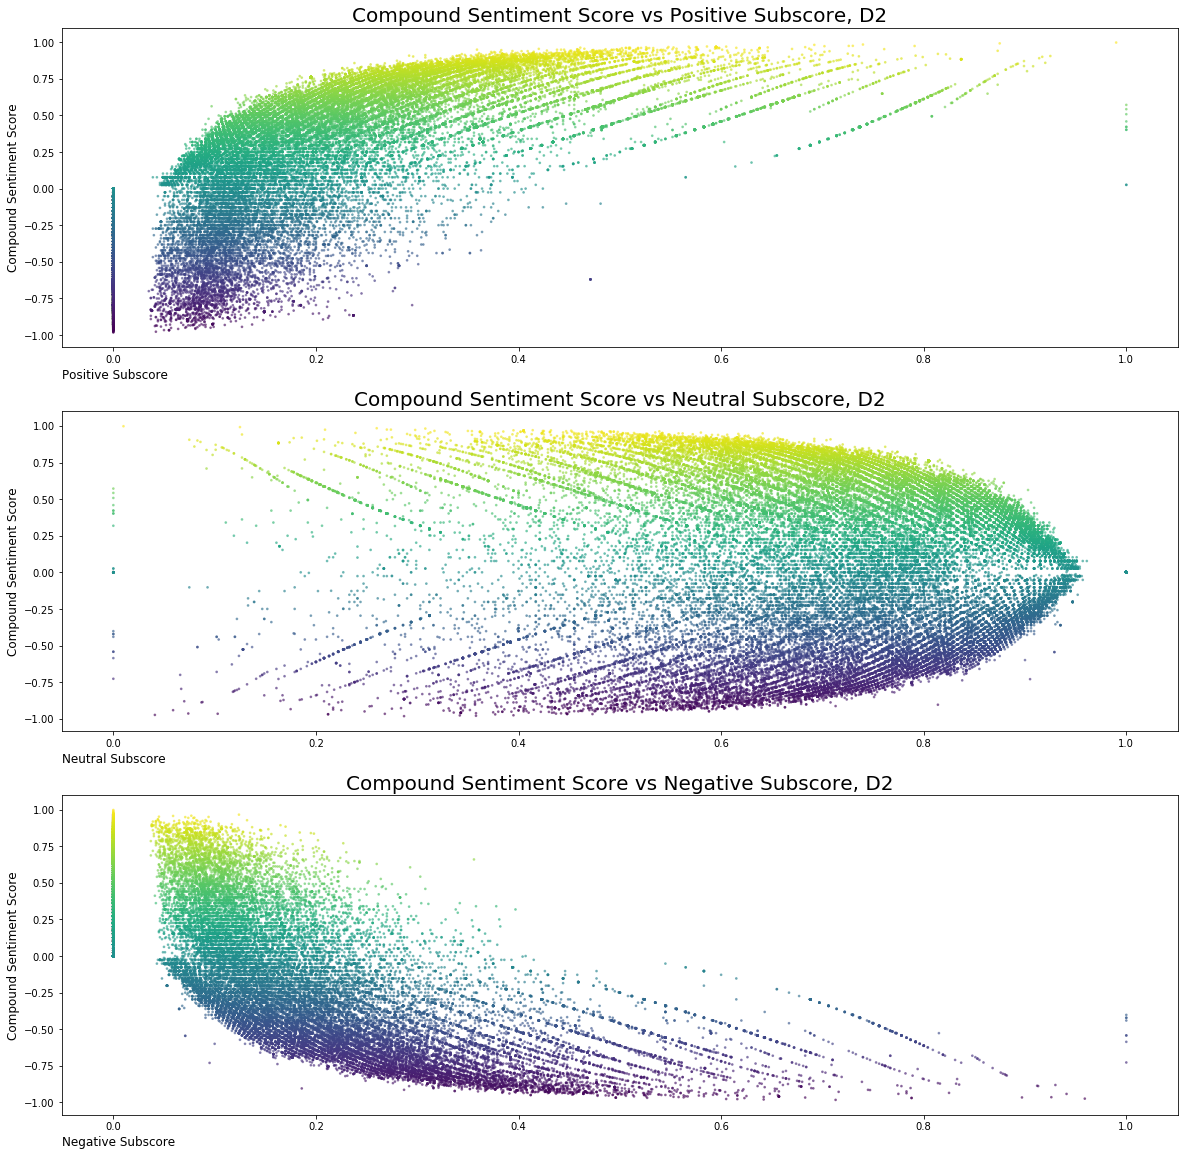

In [207]:
plt.figure(figsize=(20,20)) #set size of figure

# Compound Score versus positive score
x10 = features_scores20['pos']
y10 = features_scores20['compound']
colors10 = features_scores20['compound']
area10 = (3)  # 0 to 15 point radii

#define subplot
plt.subplot(3, 1, 1)
plt.scatter(x10, y10, s=area10, c=colors10, alpha=0.5)

# Add title and axis names
plt.title('Compound Sentiment Score vs Positive Subscore, D2',fontsize=20)
plt.xlabel('Positive Subscore',fontsize=12,horizontalalignment='left',x=0.0)
plt.ylabel('Compound Sentiment Score',fontsize=12)

#Compound Score versus neutral score
x20 = features_scores20['neu']
y20 = features_scores20['compound']
colors20 = features_scores20['compound']
area20 = (3) #arbitrary value to make trends easy to see

plt.subplot(3, 1, 2)
plt.scatter(x20, y20, s=area20, c=colors20, alpha=0.5)

# Add title and axis names and adjust fontsize
plt.title('Compound Sentiment Score vs Neutral Subscore, D2',fontsize=20)
plt.xlabel('Neutral Subscore',fontsize=12,horizontalalignment='left',x=0.0)
plt.ylabel('Compound Sentiment Score',fontsize=12)

#Compound Score versus negative score
x30 = features_scores20['neg']
y30 = features_scores20['compound']
colors30 = features_scores20['compound']
area30 = (3)  # 0 to 15 point radii

plt.subplot(3, 1, 3)
plt.scatter(x30, y30, s=area30, c=colors30, alpha=0.5)

# Add title and axis names
plt.title('Compound Sentiment Score vs Negative Subscore, D2',fontsize=20)
plt.xlabel('Negative Subscore',fontsize=12,horizontalalignment='left',x=0.0)
plt.ylabel('Compound Sentiment Score',fontsize=12)

plt.show()

Distribution of sentiment appears to be evenly distributed as before.

### Term frequency: Dataset 2

Below we continue to clean the data and check each stage of development as explained above. The process is much the same. 

Words of 2 characters or less are omitted, and words appearing less frequently than 100 times in our sample are omitted.

In [208]:
# calculate frequency by word
word_freq20 = pd.DataFrame(features_scores20.tweet_text.str.split(expand=True).stack().value_counts())

#reset index, rename columns, format
word_freq20.reset_index(level=0, inplace=True)
word_freq20.columns = ['word','frequency']
word_freq20['frequency'] = word_freq20['frequency'].apply(pd.to_numeric)

#filter out words of less than two characters in length.
word_freq21 = word_freq20[word_freq20['word'].apply(lambda x: len(x) > 2)]

#filter words that appear less frequently than 100 times in the tweets
word_freq31 = word_freq21[word_freq21.frequency > 100]

#view result
word_freq31.head(10)

word  frequency
0    the      42080
4    and      20171
8    you      12323
9    for      12257
10  this      11864
11  that      10392
14   are       6989
15  with       6448
17   The       6157
19  have       5661

In [209]:
pd.options.mode.chained_assignment = None  # default='warn'

#load stopwords
from nltk.corpus import stopwords 
stop = stopwords.words('english')

#convert to lowercase
word_freq31['word'] = word_freq31['word'].str.lower()

#remove stopwords
word_freq40 = word_freq31[~word_freq31['word'].isin(stop)]

#view result
word_freq40.head(10)

word  frequency
30         like       4097
36       people       3465
41  @mikegravel       3286
45          one       2979
54          get       2720
57         dont       2602
67        trump       2009
69         know       2000
73        would       1893
75         time       1835

Dataset 2 requires a slightly different approach; several terms were added to our filter list as you can see by the three extra lines of text in the code below. This reflects a change in the conversation in the twittersphere.

In [244]:
remove = ['like','people','one','would','get','see','know','think','make',
          'good','going','need','new','say','never','really','want','got','right',
         'cant','youre','years','love','said','trying','first','man','day','still','even',
         'take','back','ever','ive','im','also','could','every','many','better','made','says',
         'today','doesnt','way','much','time','today','year','shit','best','fucking','thing','it.',
         'someone','didnt','old','via','look','next','world','anyone','show','put','real','really','since',
         'isnt','he','she','hes','tweet','feel','tell','dont','last','work','thats','great','actually',
         'stop','video','always','call','two','things','learn','thank','theyre','called','use',
         'http','read','sure','life','gonna','bad','give','start','guy','come','please','fuck','everyone',
         'keep','getting','end','million','without','person','saying','another','must','makes',
         'something','talk','live','state','something.','week','working','ill','big','lot','well',
         'making','taking','pretty','around','name','long','let','free','remember','mean','watch',
         'using','literally','hey','thought','believe','ago','least','told','story','woman','change',
         'needs','win','part','help','game','news','vote','little','may','find','happy','nothing','public',
         'guys','human','away','enough','hope','support','pay','care','used','understand','wont','wants',
         'moment','yes','single','seen','hear','top','age','wrong','anything','twitter','history',
         'night','lol','point','done','job','die','money','hard','cool','$2000','system','far','might',
         'announcing','account','follows','random','promo','10—were','lets','turn','thread','friends','fact',
         'less','months','already','days','reason','july','group','social','came','thanks','running','retweets',
         'team']

word_freq50 = word_freq40[~word_freq40['word'].isin(remove)]

word_freq50.head(50)

word  frequency
41        @mikegravel       3286
67              trump       2009
79     @berniesanders       1744
97               @aoc       1419
125  @realdonaldtrump       1135
179               ice        808
182            bernie        789
192           country        750
205             white        692
229          campaign        629
232             biden        624
236             women        620
237           epstein        615
240           america        604
241              2020        602
268             house        535
272              mike        529
274             media        524
277          american        519
280            debate        512
290         @joebiden        493
295               war        484
296       @andrewyang        482
299           sanders        478
308         president        464
309            amazon        462
311          children        461
319            family        450
334            pelosi        434
335         democrats        433
344              kids        425
348         political        421
351            rights        417
352               joe        417
353            gravel        416
355        democratic        415
358              hate        409
360            racist        408
361            acosta        408
365               sex        404
367              left        401
371               men        398
378           workers        394
379              2019        393
386         president        389
388            trumps        388
389           climate        388
404            donors        378
406             black        373
411         americans        367

### Plotting term frequency: Dataset 2

The frequency of 50 of the most frequency terms in Dataset 2 is plotted below.

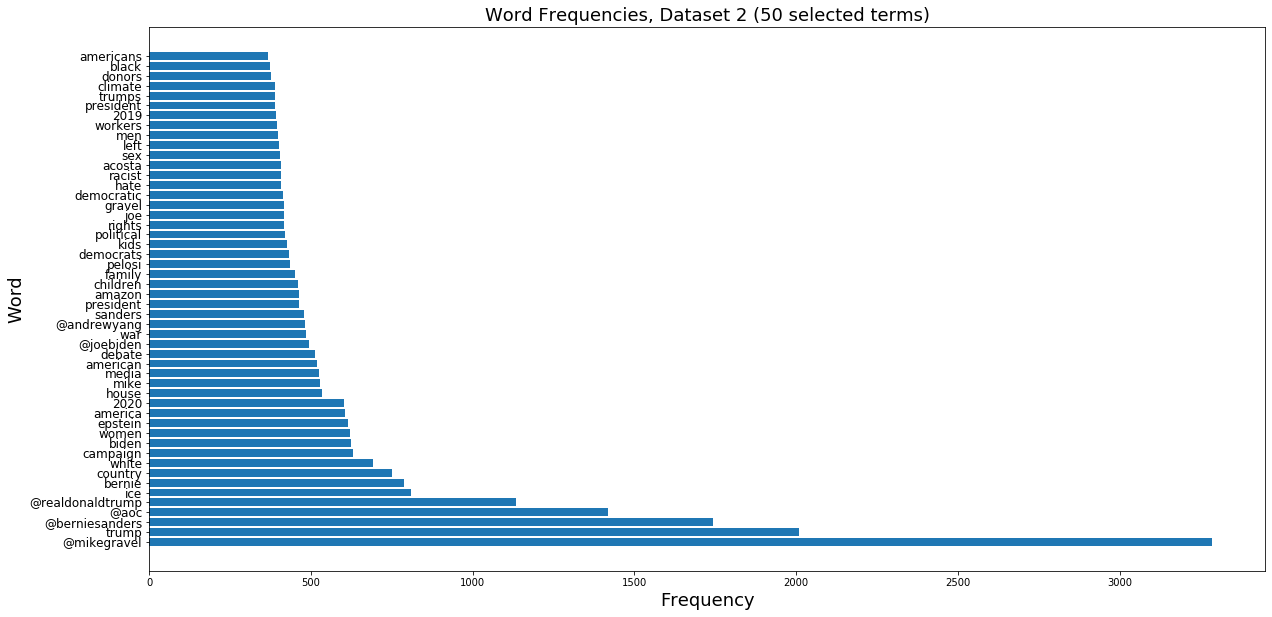

In [245]:
plt.figure(figsize=(20,10))
# this is for plotting purpose
index = np.arange(len(word_freq50['word'][:50]))
plt.barh(index, word_freq50['frequency'][:50])
plt.ylabel('Word', fontsize=18)
plt.xlabel('Frequency', fontsize=18)
plt.yticks(index, word_freq50['word'][:50], fontsize=12, rotation=0)
plt.title('Word Frequencies, Dataset 2 (50 selected terms)',fontsize=18)
plt.show()

'@mikegravel leads the pack in Dataset 2 in word frequency.

In [268]:
terms20 = list(word_freq50['word'][:50])
terms_conc20 = ' | '.join(terms20)
print(terms_conc20)

@mikegravel | trump | @berniesanders | @aoc | @realdonaldtrump | ice | bernie | country | white | campaign | biden | women | epstein | america | 2020 | house | mike | media | american | debate | @joebiden | war | @andrewyang | sanders | president | amazon | children | family | pelosi | democrats | kids | political | rights | joe | gravel | democratic | hate | racist | acosta | sex | left | men | workers | 2019 | president | trumps | climate | donors | black | americans


In [247]:
features_scores_terms20 = features_scores20[features_scores20['tweet_text'].str.contains(terms_conc20)==True]

features_scores_terms20.head(10)

tweet_text  \
71942  @BarackObama  Proud to rep Americas best team! Congrats @USWNT and thanks for being such a strong inspiration for wo...   
61892  @BarackObama  Proud to rep Americas best team! Congrats @USWNT and thanks for being such a strong inspiration for wo...   
74778  @BarackObama  Proud to rep Americas best team! Congrats @USWNT and thanks for being such a strong inspiration for wo...   
26623  @BarackObama  Proud to rep Americas best team! Congrats @USWNT and thanks for being such a strong inspiration for wo...   
75981  @BarackObama  Proud to rep Americas best team! Congrats @USWNT and thanks for being such a strong inspiration for wo...   
87008  @BarackObama  Proud to rep Americas best team! Congrats @USWNT and thanks for being such a strong inspiration for wo...   
32685  @BarackObama  Proud to rep Americas best team! Congrats @USWNT and thanks for being such a strong inspiration for wo...   
22758  @BarackObama  Proud to rep Americas best team! Congrats @USWNT and thanks for being such a strong inspiration for wo...   
97849  @BarackObama  Proud to rep Americas best team! Congrats @USWNT and thanks for being such a strong inspiration for wo...   
8515   @BarackObama  Proud to rep Americas best team! Congrats @USWNT and thanks for being such a strong inspiration for wo...   

       neg    neu    pos  compound  
71942  0.0  0.405  0.595    0.9665  
61892  0.0  0.405  0.595    0.9665  
74778  0.0  0.405  0.595    0.9665  
26623  0.0  0.405  0.595    0.9665  
75981  0.0  0.405  0.595    0.9665  
87008  0.0  0.405  0.595    0.9665  
32685  0.0  0.405  0.595    0.9665  
22758  0.0  0.405  0.595    0.9665  
97849  0.0  0.405  0.595    0.9665  
8515   0.0  0.405  0.595    0.9665

In [248]:
features_scores_terms20.tail(10)

tweet_text  \
73678  @bobpowers1  Remember that one reason Trump lost the census fight is a woman hated her racist dead dad so much that ...   
18498                 @beebinch  I hate squidward What the fuck is a “boulder”??? ? Bitch im gonna kill you   //tco/uFoScMrG1D   
96136                                @AP But what if the war cloud goes “there are no weapons of mass destruction you dummies”   
57187  @TulsiGabbard  Neocons/Neolibs   MSM all sing from the same songsheet  War war war!!! Trump never gets positive medi...   
66657  @Joe_Schmucc  These cops are trigger happy for unarmed black kids but when an actual bad guy with a gun is doing bad...   
28589  @Joe_Schmucc  These cops are trigger happy for unarmed black kids but when an actual bad guy with a gun is doing bad...   
84387  @Joe_Schmucc  These cops are trigger happy for unarmed black kids but when an actual bad guy with a gun is doing bad...   
71366  Um sorry but no @sfpelosi men that rape and conspire to rape women have never been any favorites of mine or favorit ...   
57750  @dantbarry  Police violence is gun violence even when the violence being considered is racist Islamphobic and misogy...   
94248  @ancombigirlgnat  Fuck white CEOs Fuck Black CEOs Fuck Asian CEOs Fuck Hispanic CEOs Fuck Women CEOs Fuck Jewish CEO...   

         neg    neu    pos  compound  
73678  0.478  0.522  0.000   -0.9545  
18498  0.625  0.375  0.000   -0.9563  
96136  0.567  0.433  0.000   -0.9587  
57187  0.558  0.442  0.000   -0.9633  
66657  0.496  0.448  0.055   -0.9670  
28589  0.496  0.448  0.055   -0.9670  
84387  0.496  0.448  0.055   -0.9670  
71366  0.527  0.473  0.000   -0.9684  
57750  0.623  0.377  0.000   -0.9702  
94248  0.605  0.395  0.000   -0.9764

In [249]:
features_scores_terms20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10261 entries, 71942 to 94248
Data columns (total 5 columns):
tweet_text    10261 non-null object
neg           10261 non-null float64
neu           10261 non-null float64
pos           10261 non-null float64
compound      10261 non-null float64
dtypes: float64(4), object(1)
memory usage: 481.0+ KB


We have 10,261 tweets left from our Dataset 2 sample.

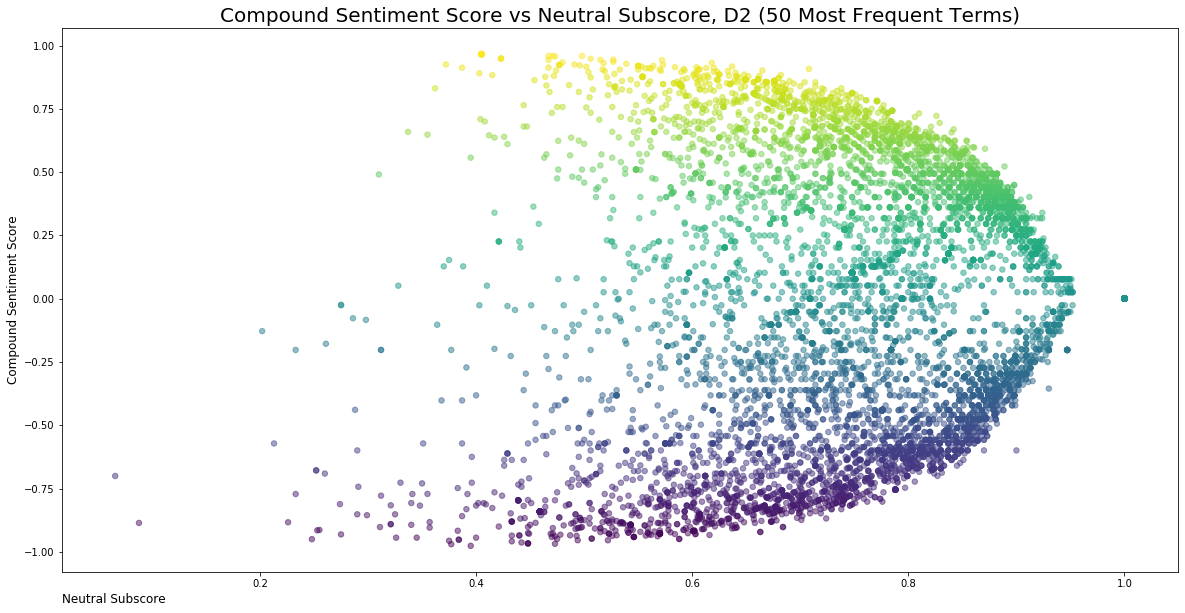

In [250]:
plt.figure(figsize=(20,10))

x = features_scores_terms20['neu']
y = features_scores_terms20['compound']
colors = features_scores_terms20['compound']
area = (30) 

plt.scatter(x, y, s=area, c=colors, alpha=0.5)

# Add title and axis names
plt.title('Compound Sentiment Score vs Neutral Subscore, D2 (50 Most Frequent Terms)',fontsize=20)
plt.xlabel('Neutral Subscore',fontsize=12,horizontalalignment='left',x=0.0)
plt.ylabel('Compound Sentiment Score',fontsize=12)

plt.show()

In [251]:
features_scores_terms21 = features_scores20[features_scores20['tweet_text'].str.contains(terms_conc20)==True]['compound'].mean()

features_scores_terms21

-0.037957957314104354

A mean compound score of -0.038 indicates a generally neutral, slightly negative sentiment in our selected tweets from Dataset 2, which is only slightly more positive than Dataset 1 at -0.095.

As before, let's plot the mean sentiment scores (positive, neutral, negative, and compound) of each of our selected terms with an indication of frequency of the occurrence in our overall sample. We'll begin by cleaning and merging the data.

In [272]:
#calculate means for each subscore
sent_means20 = []
for x in terms20:
    sent_means_neg = features_scores20[features_scores20['tweet_text'].str.contains(x)==True]['neg'].mean()
    sent_means_neu = features_scores20[features_scores20['tweet_text'].str.contains(x)==True]['neu'].mean()
    sent_means_pos = features_scores20[features_scores20['tweet_text'].str.contains(x)==True]['pos'].mean()
    sent_means_comp = features_scores20[features_scores20['tweet_text'].str.contains(x)==True]['compound'].mean()
    item = [x,sent_means_neg,sent_means_neu,sent_means_pos,sent_means_comp]
    sent_means20.append(item)

sentiment_means20 = pd.DataFrame(sent_means20,columns=['word','neg','neu','pos','compound'])

sentiment_means20.head(5)


word       neg       neu       pos  compound
0       @mikegravel  0.096750  0.764750  0.138500  0.211875
1             trump  0.090668  0.810531  0.098816  0.012297
2    @berniesanders  0.092929  0.861500  0.045571 -0.169107
3              @aoc  0.069400  0.889300  0.041300 -0.075210
4  @realdonaldtrump  0.125308  0.836692  0.038000 -0.209300

As before with Dataset 1, we can merge mean scores with word frequency data. The resulting dataframe of our 50 terms is sorted by compound score and displayed below.

In [273]:
#reset the index
WF50D2 = word_freq50.reset_index(drop=True)

#preliminary data cleaning
WF50D2.columns = WF50D2.columns.str.replace(' ', '')
sentiment_means20.columns = sentiment_means20.columns.str.replace(' ', '')

#combine duplicate terms in our original frequency dataframe and find sum of frequencies among them
WF50D2 = WF50D2.groupby('word').apply(lambda x: pd.Series(dict(frequency=(x.frequency.sum()))))

#prepare for merge
left = WF50D2
right = sentiment_means20

#merge
SMFD2 = pd.merge(left,right,on='word')
SMFD2 = SMFD2.dropna()
SMFD2 = SMFD2.drop_duplicates()

#sort by compound score
SMFD2 = SMFD2.sort_values('compound',ascending=False)

SMFD2.head(50)

word  frequency       neg       neu       pos  compound
23            donors        378  0.024812  0.888887  0.086301  0.227087
6        @mikegravel       3286  0.096750  0.764750  0.138500  0.211875
25            family        450  0.069396  0.791966  0.138637  0.168549
0               2019        393  0.033962  0.864528  0.101511  0.146185
11          american        519  0.058164  0.817247  0.124589  0.098670
37         political        421  0.070904  0.826562  0.102538  0.096839
16          campaign        629  0.065579  0.828796  0.105661  0.093267
1               2020        602  0.051776  0.858726  0.089489  0.091748
29               ice        935  0.075790  0.799506  0.124722  0.090451
20            debate        512  0.066330  0.844526  0.089180  0.089911
9             amazon        462  0.078000  0.814925  0.107075  0.088893
14             biden        624  0.070667  0.842292  0.087000  0.075617
28             house        805  0.071943  0.823365  0.104674  0.074866
22         democrats        433  0.060538  0.859785  0.079662  0.052018
35              mike        529  0.081419  0.821544  0.097028  0.051873
49           workers        394  0.081350  0.809238  0.109425  0.051468
32              left        401  0.062676  0.849987  0.087328  0.048708
42           sanders        478  0.055702  0.862734  0.081564  0.036760
34               men        398  0.079654  0.820759  0.099579  0.036757
21        democratic        521  0.053725  0.875333  0.070950  0.035095
30               joe        417  0.065219  0.855636  0.079136  0.034218
31              kids        425  0.086754  0.809430  0.103809  0.033419
33             media        524  0.077123  0.834390  0.088468  0.028764
13            bernie        789  0.082266  0.823239  0.094495  0.020493
44             trump       2146  0.090668  0.810531  0.098816  0.012297
41            rights        417  0.077094  0.839558  0.083386  0.001595
2        @andrewyang        482  0.000000  1.000000  0.000000  0.000000
24           epstein        615  0.076485  0.834939  0.088576 -0.003512
19           country        750  0.078726  0.835476  0.085793 -0.003863
10           america        604  0.094355  0.797268  0.108384 -0.011288
15             black        619  0.085395  0.831517  0.083089 -0.016030
47             white       1014  0.090472  0.816965  0.092590 -0.023073
46               war        648  0.118902  0.775206  0.105891 -0.051198
48             women        620  0.106529  0.800572  0.092896 -0.054772
26            gravel        416  0.152349  0.763825  0.083778 -0.064097
38         president        853  0.100990  0.825527  0.073481 -0.065009
3               @aoc       1419  0.069400  0.889300  0.041300 -0.075210
43               sex        404  0.117003  0.786646  0.096345 -0.084169
12         americans        367  0.088692  0.840462  0.070846 -0.091338
18           climate        388  0.111583  0.806950  0.081476 -0.092626
36            pelosi        434  0.100067  0.837844  0.062089 -0.104964
45            trumps        388  0.138158  0.771316  0.090579 -0.116837
17          children        461  0.117505  0.807916  0.074569 -0.127737
4     @berniesanders       1744  0.092929  0.861500  0.045571 -0.169107
8             acosta        408  0.116313  0.850812  0.032875 -0.178669
7   @realdonaldtrump       1135  0.125308  0.836692  0.038000 -0.209300
27              hate        409  0.207550  0.695178  0.097272 -0.278321
40            racist        408  0.265623  0.656878  0.077484 -0.520638

The term 'united' is included in tweets with the highest mean compound sentiment scores, while the word 'racist' is again our most negatively-associated term in tweets with the lowest mean sentiment. Most tweets containing our chosen terms are relatively neutral in compound sentiment scores. While '@berniesanders' marked the most positive tweets in Dataset 1, mean sentiment in Dataset 2 is slightly negative at -0.17. This indicates quite a change!

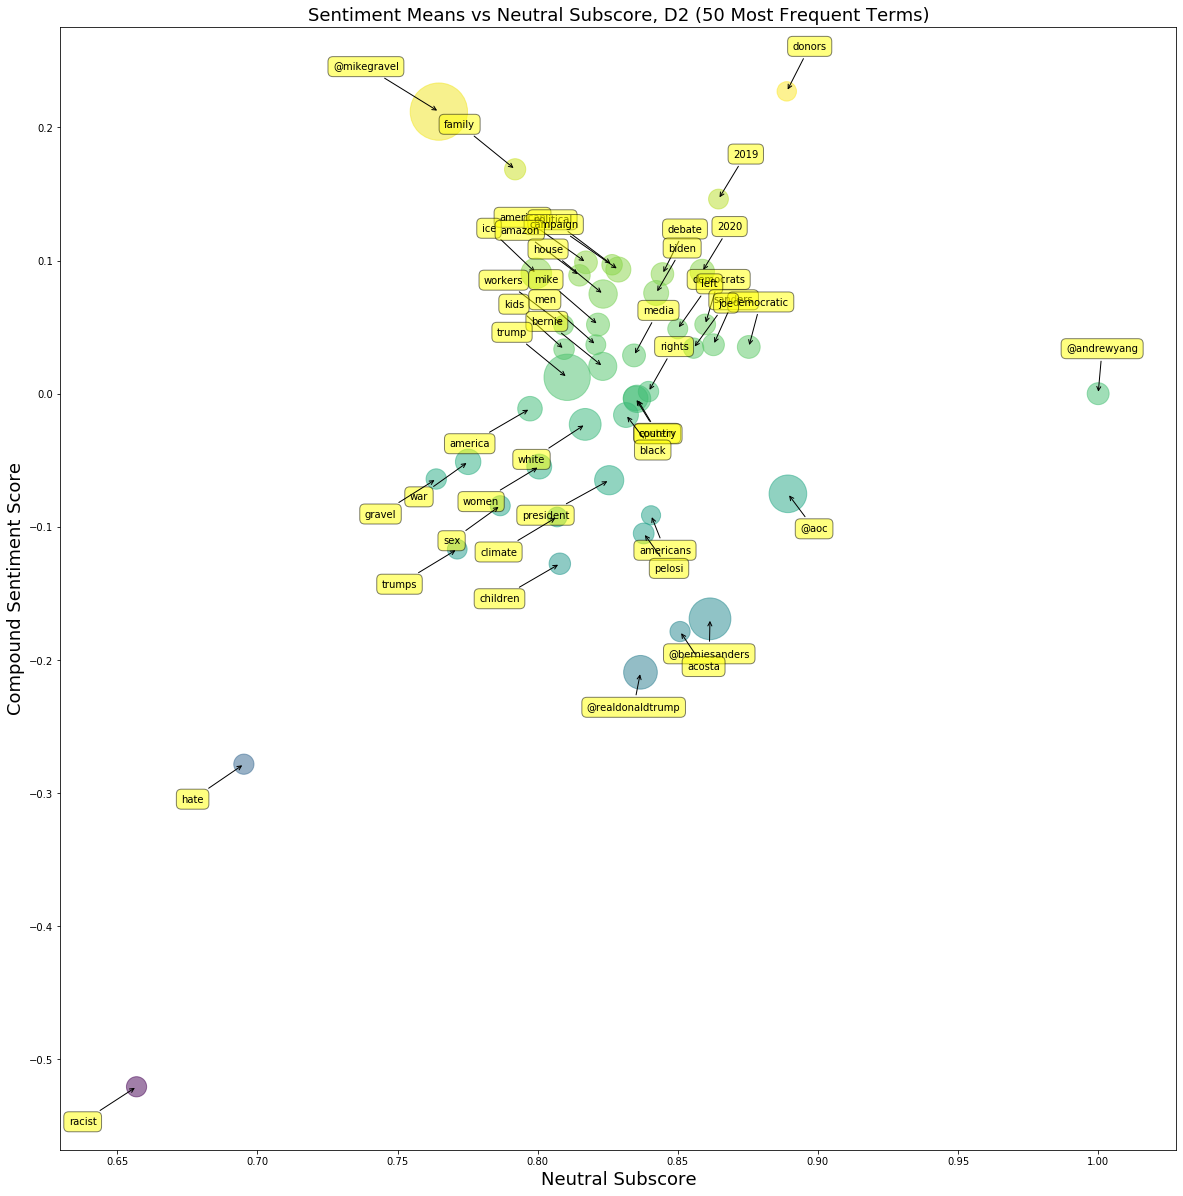

In [274]:
plt.figure(figsize=(20,20))

x = SMFD2['neu']
y = SMFD2['compound']
colors = SMFD2['compound']
area = (SMFD2['frequency']) 

labels = [i for i in SMFD2['word']]
plt.subplots_adjust(bottom = 0.1)

plt.scatter(x, y, s=area, c=colors, alpha=0.5)

# Add title and axis names
plt.title('Sentiment Means vs Neutral Subscore, D2 (50 Most Frequent Terms)',fontsize=18)
plt.xlabel('Neutral Subscore',fontsize=18)
plt.ylabel('Compound Sentiment Score',fontsize=18)

for label, x, y in zip(labels, SMFD2['neu'], SMFD2['compound']):
    flip = 2
    if x < .83: flip = -2
        
    flop = 2
    if y < 0: flop = -2
    plt.annotate(
        label,
        xy=(x, y), xytext=(20*flip, 20*flop),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.show()

'@mikegravel' leads the pack with frequency, mentioned in tweets with generally positive mean compound sentiment. 'Racist' is used in the most negative tweets. '@tulsigabbard', 'united' and 'party' lead in postive sentiment. As observed in the dataframe displayed above, '@berniesanders' is mentioned mostly in neutral, negative tweets.

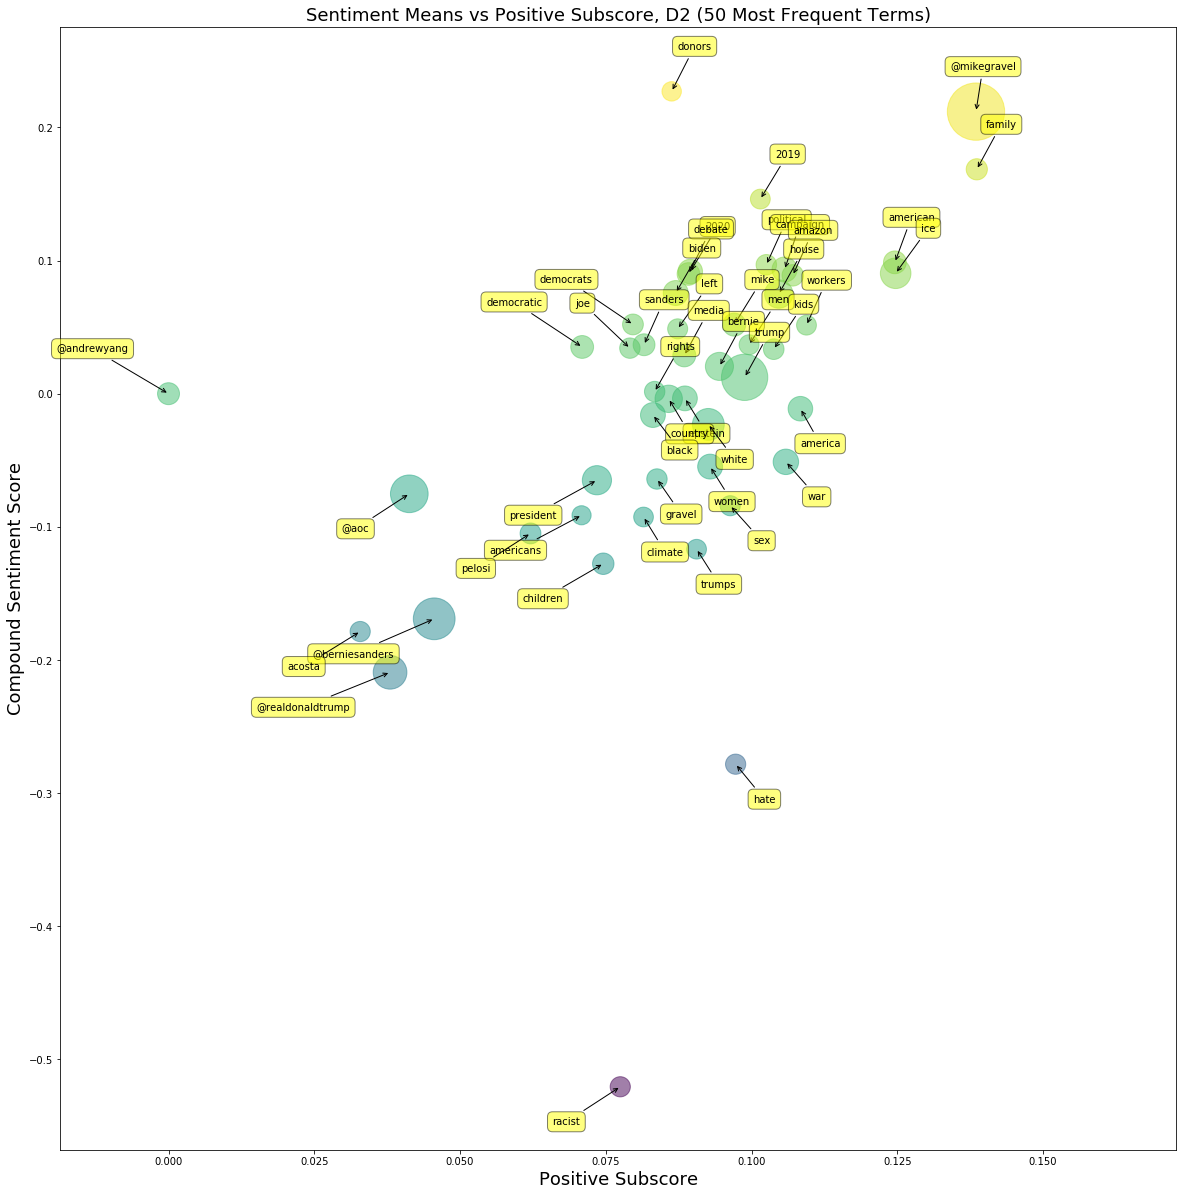

In [275]:
plt.figure(figsize=(20,20))

x = SMFD2['pos']
y = SMFD2['compound']
colors = SMFD2['compound']
area = (SMFD2['frequency']) 

labels = [i for i in SMFD2['word']]
plt.subplots_adjust(bottom = 0.1)

plt.scatter(x, y, s=area, c=colors, alpha=0.5)

# Add title and axis names
plt.title('Sentiment Means vs Positive Subscore, D2 (50 Most Frequent Terms)',fontsize=18)
plt.xlabel('Positive Subscore',fontsize=18)
plt.ylabel('Compound Sentiment Score',fontsize=18)

for label, x, y in zip(labels, SMFD2['pos'], SMFD2['compound']):
    flip = 2
    if x < .08: flip = -2
        
    flop = 2
    if y < 0: flop = -2
    plt.annotate(
        label,
        xy=(x, y), xytext=(20*flip, 20*flop),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.show()

A different plot exposes data points hidden by overlapping labels.

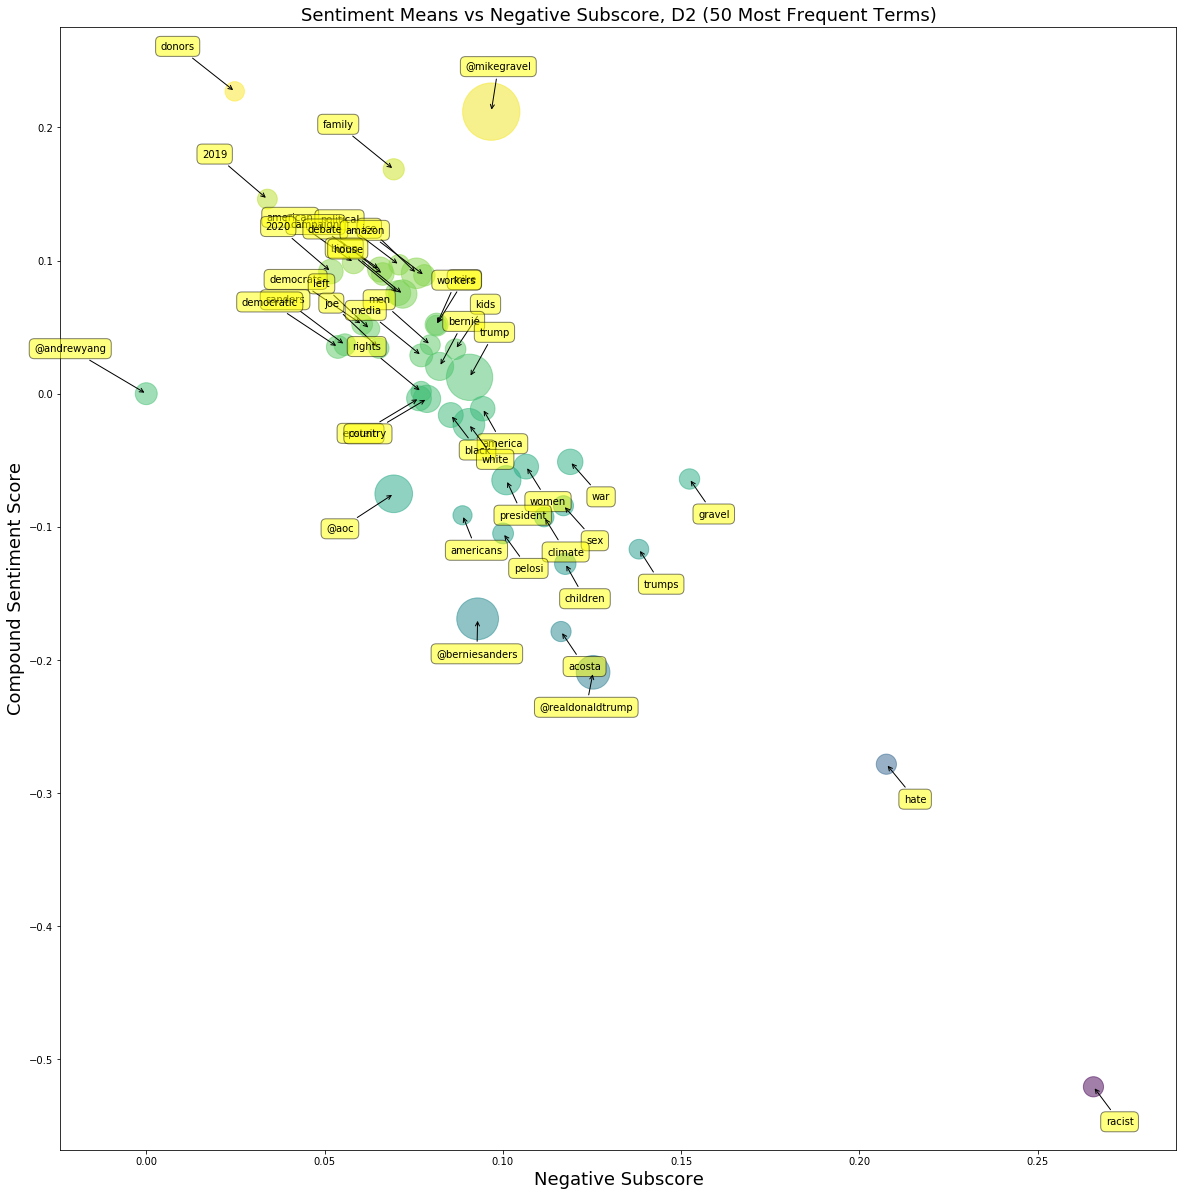

In [276]:
plt.figure(figsize=(20,20))

x = SMFD2['neg']
y = SMFD2['compound']
colors = SMFD2['compound']
area = (SMFD2['frequency']) 

labels = [i for i in SMFD2['word']]
plt.subplots_adjust(bottom = 0.1)

plt.scatter(x, y, s=area, c=colors, alpha=0.5)

# Add title and axis names
plt.title('Sentiment Means vs Negative Subscore, D2 (50 Most Frequent Terms)',fontsize=18)
plt.xlabel('Negative Subscore',fontsize=18)
plt.ylabel('Compound Sentiment Score',fontsize=18)

for label, x, y in zip(labels, SMFD2['neg'], SMFD2['compound']):
    flip = 2
    if x < .08: flip = -2
        
    flop = 2
    if y < 0: flop = -2
        
    plt.annotate(
        label,
        xy=(x, y), xytext=(20*flip, 20*flop),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.show()

Lurking, again, in the midst of the centered cluster is one of our most-frequently tweeted terms: 'trump'. Sentiment for the tweets containing this term are again surprisingly marginally negative and centered at a 0 compound score.  


## Comparison: Dataset 1 and Dataset 2 

With data cleaned and prepared, let's merge data from both datasets to compare ascending or descending trends.

We'll begin by compiling a list of the combined chosen terms.

In [277]:
mylist = terms20+terms
mylist = set(mylist)
terms_combined = list(mylist)

print(terms_combined)

['bernie', 'iraq', 'white', 'trump', 'climate', 'house', 'political', 'left', '@aoc', 'sex', '2020', 'school', 'pelosi', 'warren', 'american', 'children', '@ilhanmn', 'acosta', 'america', 'men', 'trumps', 'war', 'sanders', 'police', 'concentration', '@realdonaldtrump', 'administration', '@thejalatucker', '@tulsigabbard', 'juneteenth', 'ice', '@andrewyang', 'campaign', 'media', 'gravel', 'women', '2019', 'party', 'donors', 'biden', 'democratic', 'military', 'mike', 'epstein', 'camps', 'amazon', 'rights', 'americans', 'debate', '@joebiden', 'family', 'government', 'hate', '@mikegravel', 'president', 'racist', '@ewarren', '@berniesanders', 'black', 'iran', 'country', 'democrats', 'joe', 'drone', 'united', 'kids', 'workers']


Now we pull data from Datasets 1 and 2 for the terms listed above.

In [278]:
#calculate means for each subscore
sent_means = []
for x in terms_combined:
    sent_means_neg1 = features_scores[features_scores['tweet_text'].str.contains(x)==True]['neg'].mean()
    sent_means_neu1 = features_scores[features_scores['tweet_text'].str.contains(x)==True]['neu'].mean()
    sent_means_pos1 = features_scores[features_scores['tweet_text'].str.contains(x)==True]['pos'].mean()
    sent_means_comp1 = features_scores[features_scores['tweet_text'].str.contains(x)==True]['compound'].mean()
    sent_means_neg2 = features_scores20[features_scores20['tweet_text'].str.contains(x)==True]['neg'].mean()
    sent_means_neu2 = features_scores20[features_scores20['tweet_text'].str.contains(x)==True]['neu'].mean()
    sent_means_pos2 = features_scores20[features_scores20['tweet_text'].str.contains(x)==True]['pos'].mean()
    sent_means_comp2 = features_scores20[features_scores20['tweet_text'].str.contains(x)==True]['compound'].mean()
    item = [x,sent_means_neg1,sent_means_neu1,sent_means_pos1,sent_means_comp1,
           sent_means_neg2,sent_means_neu2,sent_means_pos2,sent_means_comp2]
    sent_means.append(item)

sentiment_means_combined = pd.DataFrame(sent_means,columns=['word','neg1','neu1','pos1','compound1',
                                                            'neg2','neu2','pos2','compound2'])

sentiment_means_combined.head()


word      neg1      neu1      pos1  compound1      neg2      neu2  \
0   bernie  0.068522  0.821051  0.110434   0.127748  0.082266  0.823239   
1     iraq  0.124625  0.750625  0.124625   0.027600  0.189750  0.758500   
2    white  0.090952  0.799705  0.109399   0.041827  0.090472  0.816965   
3    trump  0.111187  0.794339  0.094479  -0.036823  0.090668  0.810531   
4  climate  0.099582  0.820399  0.080084  -0.073201  0.111583  0.806950   

       pos2  compound2  
0  0.094495   0.020493  
1  0.051750  -0.353400  
2  0.092590  -0.023073  
3  0.098816   0.012297  
4  0.081476  -0.092626

In [283]:
#prepare for merge
left = WF50D2
right = sentiment_means_combined

#merge
comparison = pd.merge(left,right,on='word')
comparison = comparison.dropna()
comparison = comparison.drop_duplicates()

comparison = comparison.rename(index=str, columns={"frequency": "frequency2"})

#prepare for merge
left = WF50
right = comparison

#merge
comparison = pd.merge(left,right,on='word')
comparison = comparison.dropna()
comparison = comparison.drop_duplicates()

comparison = comparison.rename(index=str, columns={"frequency": "frequency1"})

#sort by compound score
comparison = comparison.sort_values('compound2',ascending=False)

comparison.head(50)

word  frequency1  frequency2      neg1      neu1      pos1  \
50          united         351         270  0.059324  0.738529  0.202147   
39           party         553         549  0.083856  0.722390  0.193771   
6      @mikegravel         909        3286  0.000000  1.000000  0.000000   
25          family         280         450  0.078492  0.803819  0.117718   
0             2019         297         393  0.046482  0.845984  0.107538   
11        american         674         519  0.106759  0.800190  0.093013   
41       political         287         421  0.104659  0.800190  0.095111   
16        campaign         353         629  0.050125  0.839843  0.110039   
1             2020         298         602  0.048437  0.866329  0.085238   
29             ice         359         935  0.076151  0.802457  0.121403   
22          debate         270         512  0.080283  0.826321  0.093394   
9           amazon         114         462  0.057452  0.803645  0.138935   
30            iran        2441         239  0.207676  0.702549  0.089782   
14           biden         865         624  0.080537  0.847418  0.072060   
28           house         437         805  0.065784  0.838905  0.095311   
24       democrats         296         433  0.081659  0.799114  0.119136   
37            mike         200         529  0.085750  0.817167  0.097083   
55         workers         183         394  0.075880  0.821005  0.103129   
34            left         342         401  0.076829  0.833074  0.090093   
45         sanders         457         478  0.044489  0.843766  0.111745   
36             men         391         398  0.091832  0.816379  0.091785   
23      democratic         349         521  0.052855  0.891040  0.056097   
32             joe         553         417  0.070795  0.845037  0.084172   
33            kids         454         425  0.089051  0.827220  0.083705   
35           media         522         524  0.113575  0.811622  0.074795   
13          bernie         989         789  0.068522  0.821051  0.110434   
52          warren         430         243  0.100597  0.797271  0.102130   
48           trump        2320        2146  0.111187  0.794339  0.094479   
46          school         694         308  0.040264  0.920168  0.039574   
5         @ewarren         360         240  0.100315  0.802501  0.097181   
44          rights         332         417  0.056344  0.849589  0.094064   
2      @andrewyang         212         482  0.000000  1.000000  0.000000   
21         country         753         750  0.099182  0.836040  0.064765   
10         america         515         604  0.089547  0.812156  0.098273   
15           black         714         619  0.104825  0.808865  0.086294   
20   concentration         860         246  0.074941  0.850156  0.074908   
53           white         734        1014  0.090952  0.799705  0.109399   
26      government         374         348  0.119613  0.810091  0.070294   
17           camps         796         262  0.084883  0.848299  0.066823   
51             war        2240         648  0.170417  0.736249  0.093327   
54           women         419         620  0.105220  0.800987  0.093797   
42       president         894         853  0.089187  0.832373  0.078449   
38        military         347         266  0.111134  0.815365  0.073436   
3             @aoc        1223        1419  0.062333  0.819333  0.118333   
47             sex         159         404  0.115286  0.798654  0.086071   
12       americans         320         367  0.126294  0.818882  0.054706   
19         climate         373         388  0.099582  0.820399  0.080084   
8   administration         339         170  0.102289  0.798480  0.099183   
49          trumps         303         388  0.094588  0.770706  0.134706   
18        children         705         461  0.109722  0.817633  0.072630   

    compound1      neg2      neu2      pos2  compound2  
50   0.316212  0.055014  0.754639  0.190236   0.350531  
39   0.255729  0.072885

In [320]:
comparison_c = comparison[['compound1','compound2']].T

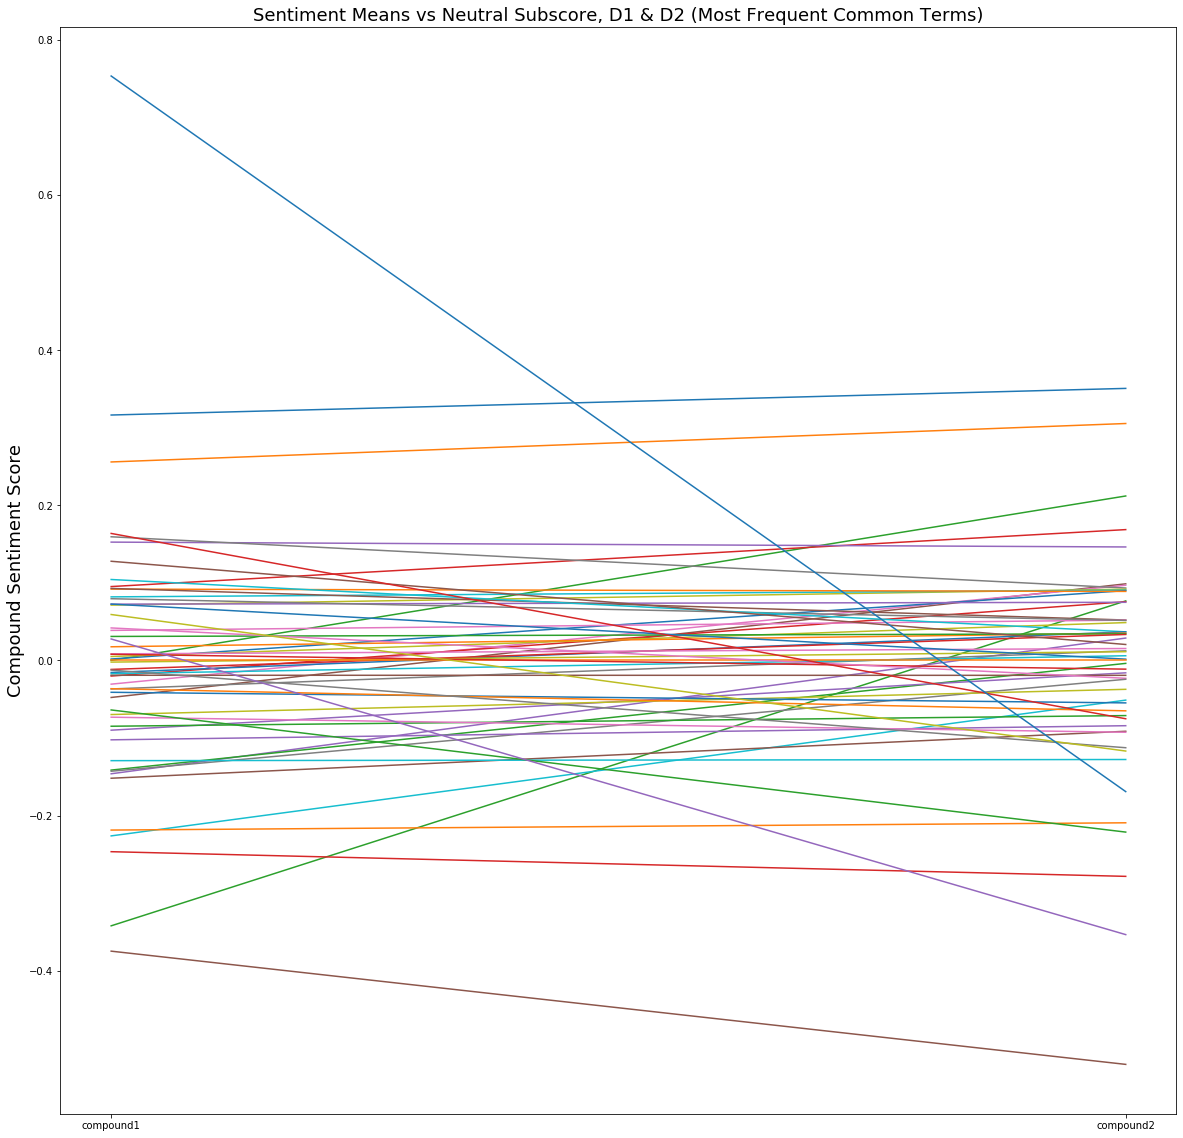

In [323]:
plt.figure(figsize=(20,20))

# multiple line plot
plt.plot(comparison_c)


# Add title and axis names
plt.title('Sentiment Means vs Neutral Subscore, D1 & D2 (Most Frequent Common Terms)',fontsize=18)
plt.ylabel('Compound Sentiment Score',fontsize=18)

plt.show()

From the plot above we see there are few words with remarkably changing sentiment. Let's calculate and plot differences in frequency and sentiment for the the selected words.

In [343]:
comparison['compound_diff'] = comparison['compound2'] - comparison['compound1']
comparison['frequency_diff'] = comparison['frequency2'] - comparison['frequency1']

comparison = comparison.reset_index(drop=True)
comparison.head(3)

word  frequency1  frequency2      neg1      neu1      pos1  \
0       united         351         270  0.059324  0.738529  0.202147   
1        party         553         549  0.083856  0.722390  0.193771   
2  @mikegravel         909        3286  0.000000  1.000000  0.000000   

   compound1      neg2      neu2      pos2  compound2  compound_diff  \
0   0.316212  0.055014  0.754639  0.190236   0.350531       0.034319   
1   0.255729  0.072885  0.727789  0.199351   0.305272       0.049543   
2   0.000000  0.096750  0.764750  0.138500   0.211875       0.211875   

   frequency_diff  
0             -81  
1              -4  
2            2377

## Change in Mean Compound Sentiment

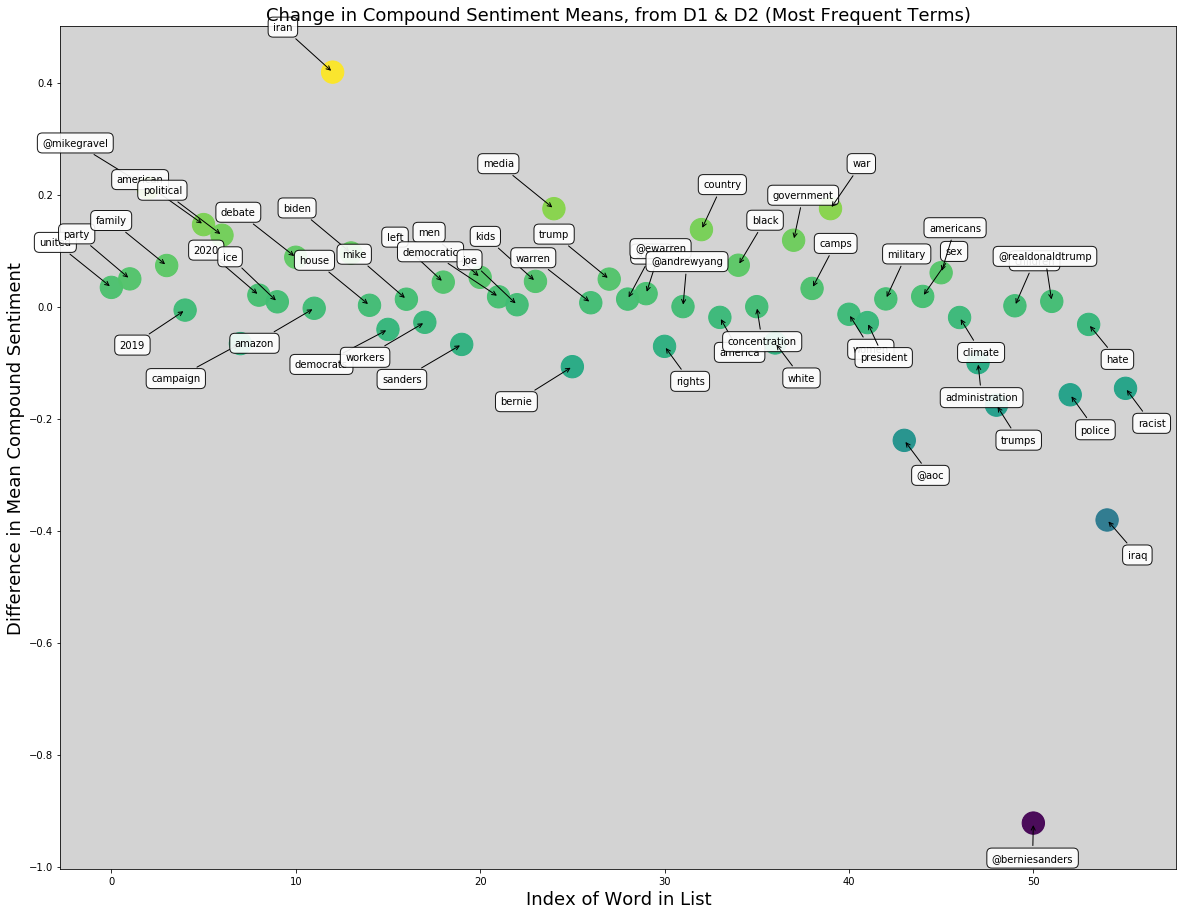

In [358]:
plt.figure(figsize=(20,15))

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'lightgray'

x = comparison.index
y = comparison['compound_diff']
colors = comparison['compound_diff']
area = (500) 

labels = [i for i in comparison['word']]
plt.subplots_adjust(bottom = 0.1)

plt.scatter(x, y, s=area, c=colors, alpha=0.95)

# Add title and axis names
plt.title('Change in Compound Sentiment Means, from D1 & D2 (Most Frequent Terms)',fontsize=18)
plt.xlabel('Index of Word in List',fontsize=18)
plt.ylabel('Difference in Mean Compound Sentiment',fontsize=18)

for label, x, y in zip(labels, comparison.index, comparison['compound_diff']):
    flip = 2
    if x < 28: flip = -2
        
    flop = 2
    if y < 0: flop = -2
        
    plt.annotate(
        label,
        xy=(x, y), xytext=(20*flip, 20*flop),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.9),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.show()

As mentioned before in these analyses, '@berniesanders' has lost its inclusion in tweets deemed positive; this could be simply a matter of retweets which mention negative concepts such as 'resistance' or 'hate' or 'fight'. Additionally, '@aoc' has met with the same sort of trend, as has 'Iraq'. 'Iran' has fared better; as previously mentioned, the tensions that plagued the news cycle 22 days ago has largely been forgotten in the Twittersphere. Sentiment for most other terms seems to have held mostly steady.

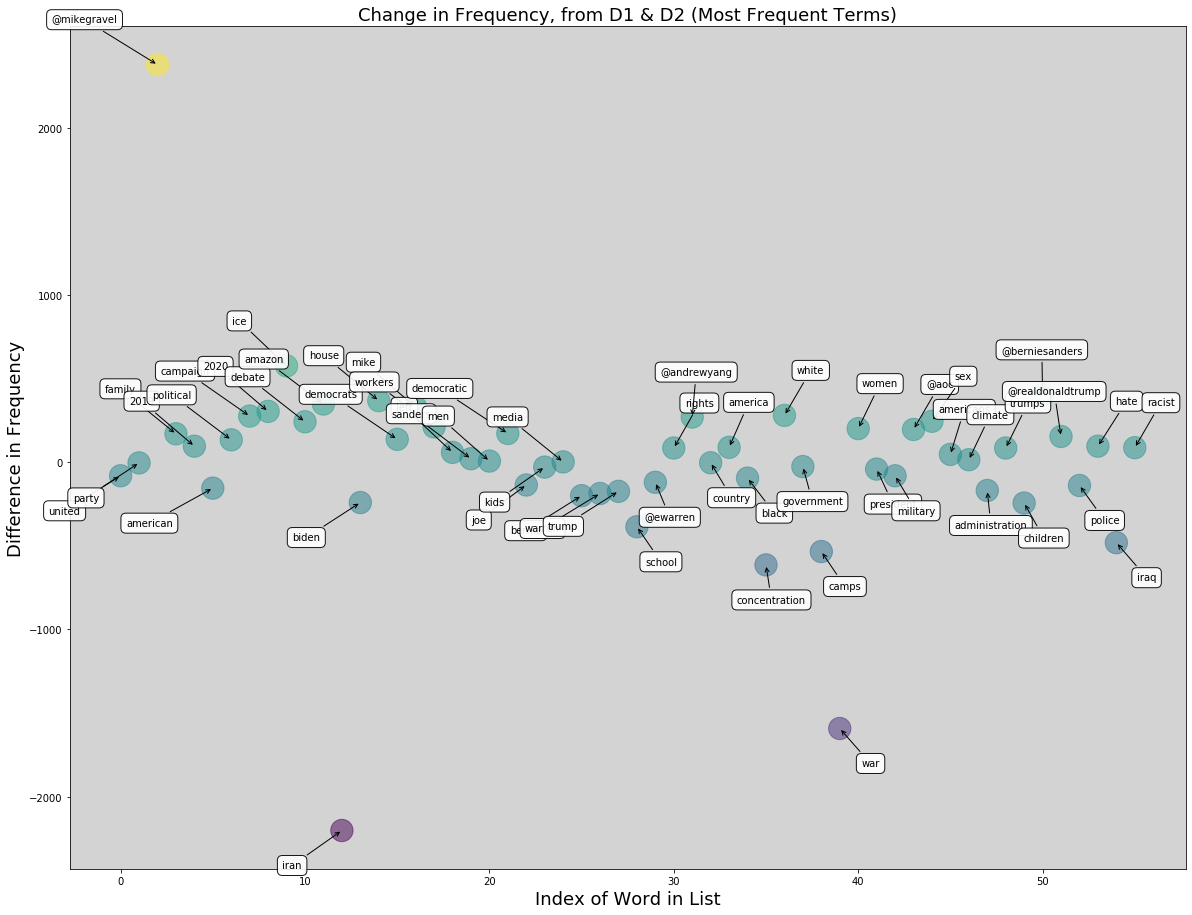

In [356]:
plt.figure(figsize=(20,15))

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'lightgray'

x = comparison.index
y = comparison['frequency_diff']
colors = comparison['frequency_diff']
area = (500) 

labels = [i for i in comparison['word']]
plt.subplots_adjust(bottom = 0.1)

plt.scatter(x, y, s=area, c=colors, alpha=0.5)

# Add title and axis names
plt.title('Change in Frequency, from D1 & D2 (Most Frequent Terms)',fontsize=18)
plt.xlabel('Index of Word in List',fontsize=18)
plt.ylabel('Difference in Frequency',fontsize=18)

for label, x, y in zip(labels, comparison.index, comparison['frequency_diff']):
    flip = 2
    if x < 28: flip = -2
        
    flop = 2
    if y < 0: flop = -2
        
    plt.annotate(
        label,
        xy=(x, y), xytext=(20*flip, 20*flop),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.9),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.show()

This plot confirms the observations in these analyses; mentions of Iran and war decreased significantly, while mentions of @mikegravel seem to have skyrocketed. The terms 'concentration' and 'camps' have decreased as well, while 'ICE' is on the rise. The bottom have of the plot represents terms and concepts moving out of the collective short-term memory. 